### Imports

In [547]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
if platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
    sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### NRK TODO:
0) Run sanity checks on PF construction - are we combining each way or keeping separate? Is that the best method? What if the rat flips the direction around after SD?
1) Remove bad SD sessions with only a few remaze laps
2) Figure out why there is more rate-remapping in the same position bin for SD than NSD but ONLY WHEN I normalize each maze to itself.

### Visualize running behavior for all rats and tally lap #s by hand

In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [489]:
sess.paradigm.to_dataframe().duration/3600

0    2.024444
1    0.939167
2    9.019722
3    5.000000
4    4.019722
5    1.079444
Name: duration, dtype: float64

In [491]:
sess.paradigm.to_dataframe()

start   stop    label  duration
0      0   7288      pre      7288
1   7302  10683     maze      3381
2  10685  43156     post     32471
3  10685  28685       sd     18000
4  28685  43156       rs     14471
5  43157  47043  re-maze      3886

In [5]:
t_bw, t_sd = [], []
for sess in subjects.remaze_sess()[1:]:
    t_bw.append((sess.paradigm['re-maze'].starts[0] - sess.paradigm['maze'].stops[0])/60/60)

t_bw

[9.017222222222221,
 9.014444444444445,
 8.937222222222223,
 9.333888888888888,
 9.003333333333334,
 9.059722222222224,
 9.022777777777778,
 9.020555555555555]

In [493]:
sessions[5]

ProcessData(RatU_Day4SD_2021-07-29_08-23-06.xml)

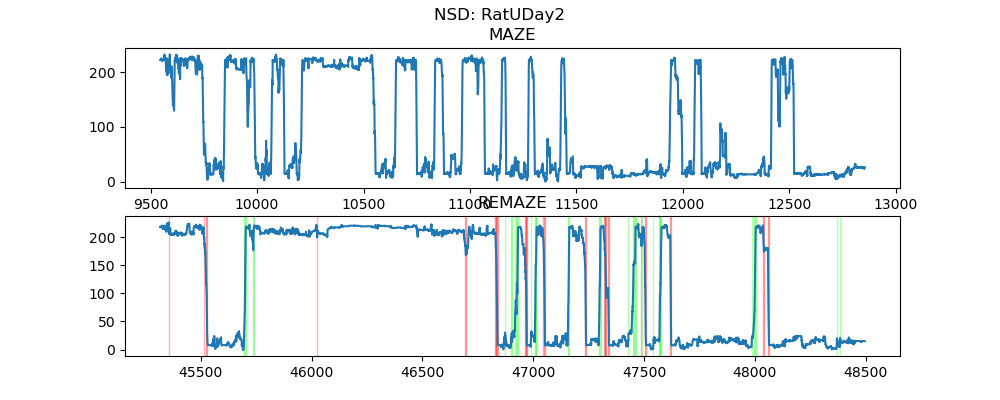

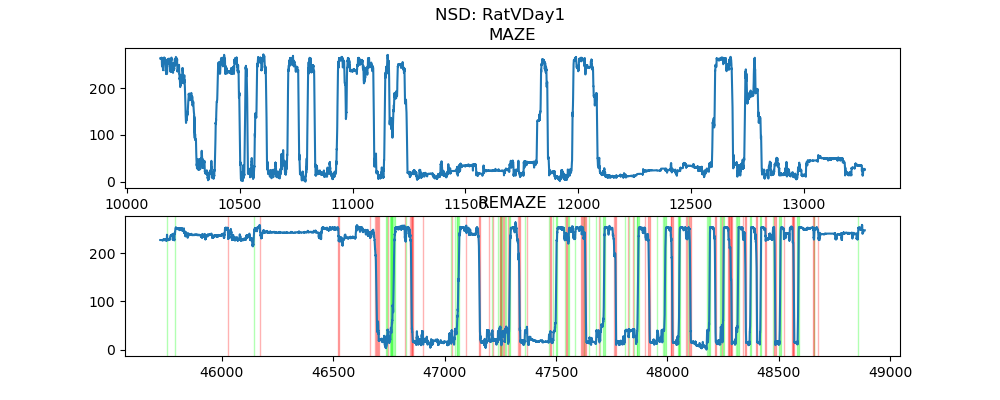

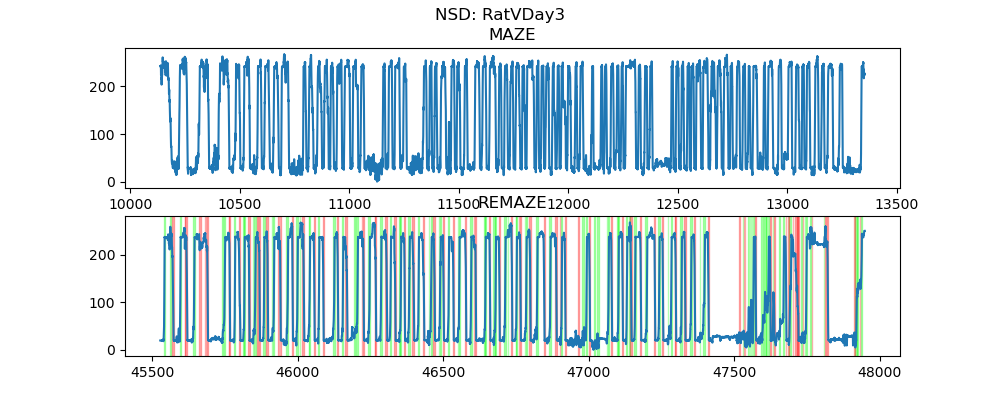

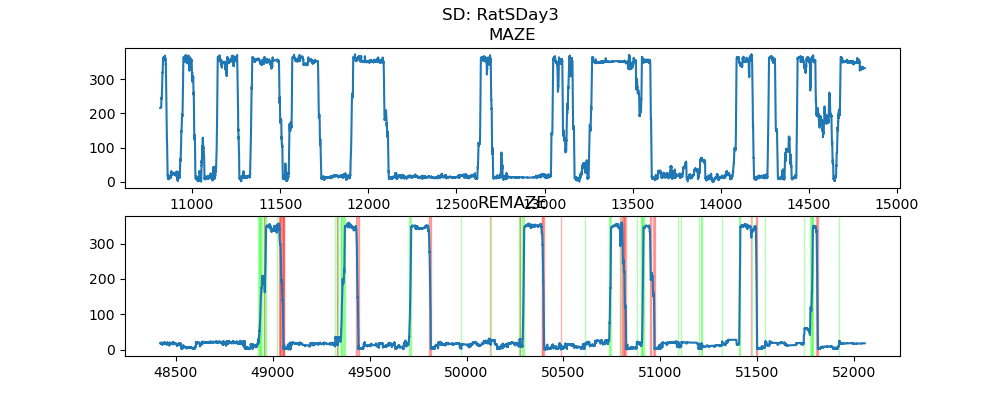

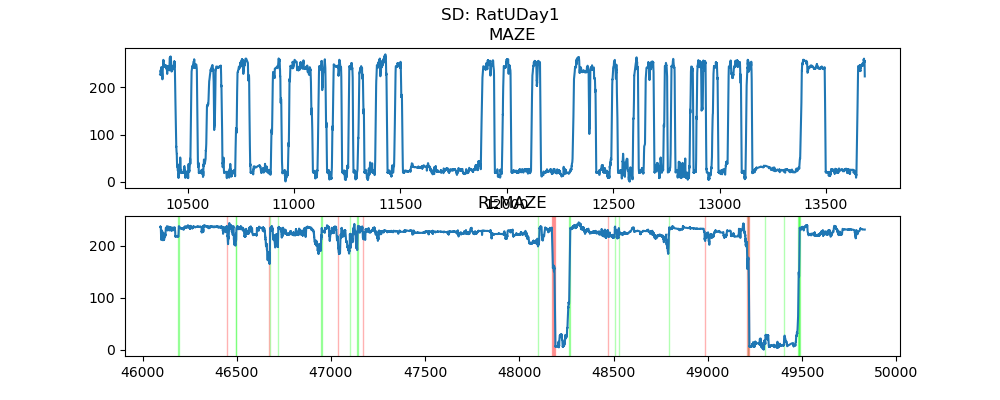

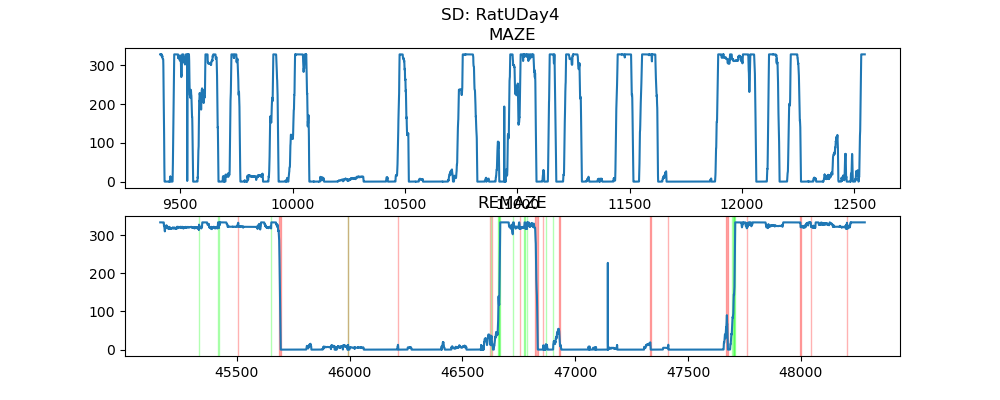

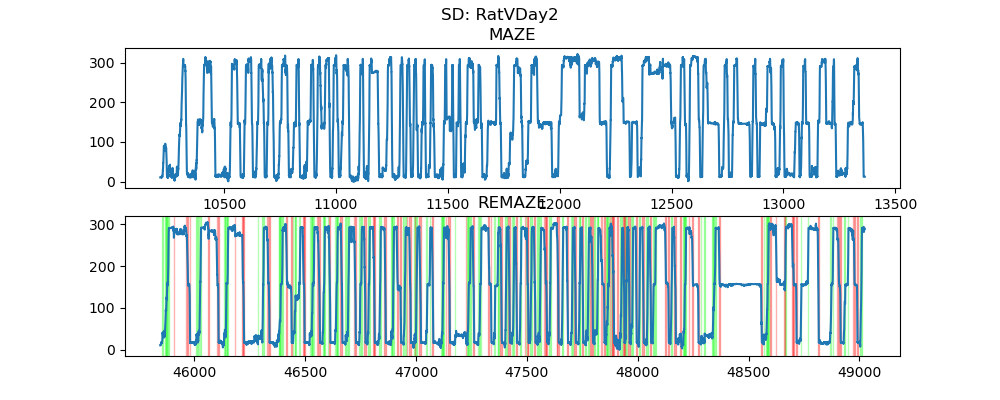

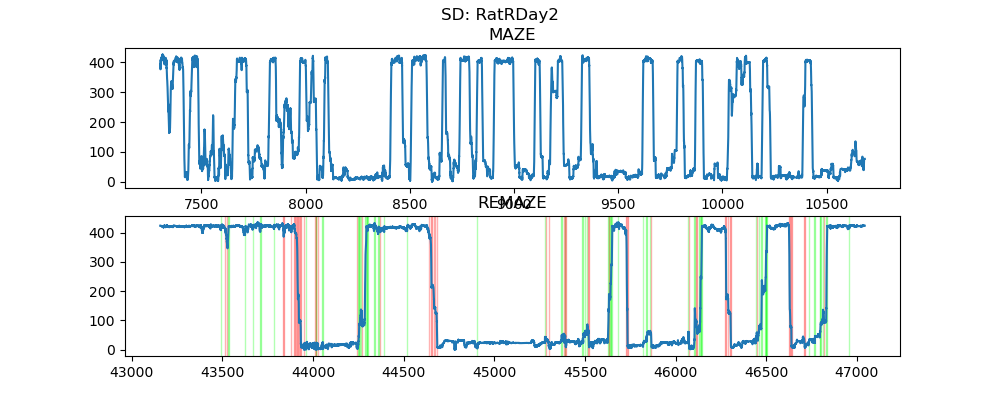

In [6]:
%matplotlib widget
for sess in subjects.remaze_sess()[1:]:
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    fig.suptitle(f"{sess.tag}: {sess.name}")
    ax[0].plot(sess.maze.time, sess.maze.x)
    ax[0].set_title("MAZE")
    ax[1].plot(sess.remaze.time, sess.remaze.x)
    ax[1].set_title("REMAZE")
    for col, dir in zip([[0, 1, 0, 0.3], [1, 0, 0, 0.3]], ["up", "down"]):
        for start, stop in zip(sess.remaze_run[dir].starts, sess.remaze_run[dir].stops):
            ax[1].axvspan(start, stop, color=col)

### Placefields and population vector correlation MAZE vs REMAZE

In [292]:
tc_new_df.session.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [724]:
pfmaze.resample_1D(50).tuning_curves.shape

(30, 50)

In [726]:
pfremaze.resample_1D(50).tuning_curves.shape

(30, 50)

In [897]:
neurons

Neurons
 n_neurons: 30
 t_start: 0.0
 t_stop: 47043.7208
 neuron_type: ['pyr']

In [903]:
tc_maze[0].shape

(30, 50)

In [899]:
tc_comb.shape

(60, 100)

In [908]:
[sess.neurons_stable.get_neuron_type("pyr").n_neurons for s, sess in enumerate(sessions)]

[151, 37, 39, 43, 35, 98, 28, 30]

In [930]:
tc_all.groupby(["grp", "session"]).count()

0    1    2    3    4    5    6    7    8    9   ...   90   91  \
grp session                                                    ...             
NSD 0        151  151  151  151  151  151  151  151  151  151  ...  151  151   
    1         37   37   37   37   37   37   37   37   37   37  ...   37   37   
    2         39   39   39   39   39   39   39   39   39   39  ...   39   39   
SD  3         43   43   43   43   43   43   43   43   43   43  ...   43   43   
    4         35   35   35   35   35   35   35   35   35   35  ...   35   35   
    5         98   98   98   98   98   98   98   98   98   98  ...   98   98   
    6         28   28   28   28   28   28   28   28   28   28  ...   28   28   
    7         30   30   30   30   30   30   30   30   30   30  ...   30   30   

              92   93   94   95   96   97   98   99  
grp session                                          
NSD 0        151  151  151  151  151  151  151  151  
    1         37   37   37   37   37   37   37   37  
    2         39   39   39   39   39   39   39   39  
SD  3         43   43   43   43   43   43   43   43  
    4         35   35   35   35   35   35   35   35  
    5         98   98   98   98   98   98   98   98  
    6         28   28   28   28   28   28   28   28  
    7         30   30   30   30   30   30   30   30  

[8 rows x 100 columns]

Methodology for getting placefield plots below
1) Grab stable pyramidal neurons
2) Break up each session into run directions
3) Calculate place field for each cell x run direction combination. Note that this results in **doubling your neuron count in all figures below!**

In [472]:
np.diagonal(np.corrcoef(tc_maze, tc_remaze), offset=pfmaze.n_neurons)

array([-0.08063008, -0.11747911,  0.57779184,  0.65833456, -0.19824357,
        0.60801507,  0.10455484,  0.23482818,  0.41826125,  0.01681654,
       -0.04833782,  0.48937625,  0.786822  ,  0.19141314, -0.07719792,
        0.0426414 ,  0.07392998,         nan,  0.48727433,  0.1072497 ,
        0.52267531, -0.00926494,  0.20407861,  0.24573726,  0.26253535,
        0.5743069 ,  0.22599841,  0.2483302 ,  0.3842132 ,  0.11452591])

In [470]:
corr_temp = []
for i, (maze_tci, remaze_tci) in enumerate(zip(tc_maze, tc_remaze)):
    corr_temp.append(np.corrcoef(maze_tci, remaze_tci)[0, 1])
np.array(corr_temp)

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([-0.08063008, -0.11747911,  0.57779184,  0.65833456, -0.19824357,
        0.60801507,  0.10455484,  0.23482818,  0.41826125,  0.01681654,
       -0.04833782,  0.48937625,  0.786822  ,  0.19141314, -0.07719792,
        0.0426414 ,  0.07392998,         nan,  0.48727433,  0.1072497 ,
        0.52267531, -0.00926494,  0.20407861,  0.24573726,  0.26253535,
        0.5743069 ,  0.22599841,  0.2483302 ,  0.3842132 ,  0.11452591])

In [523]:
### Downsample test code
sess = sessions[0]
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")

pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    


In [545]:
np.where(5 == [6, 7, 8])[0].min()

ValueError: zero-size array to reduction operation minimum which has no identity

/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


Text(0.5, 1.0, 'Downsampled to Match')

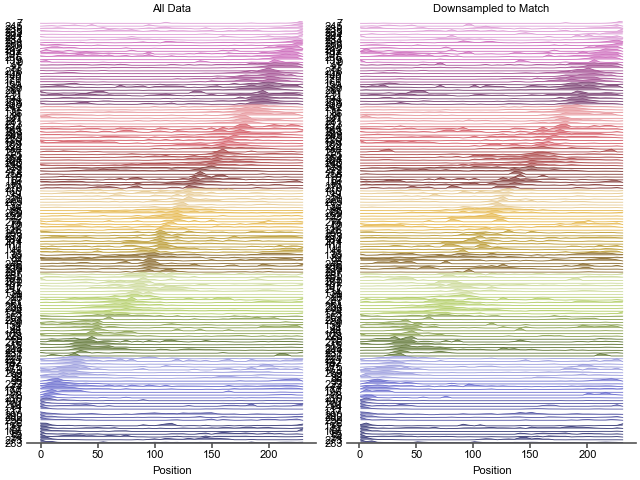

In [565]:
def downsample_maze(pfmaze_in: Pf1D, posmaze_in: Position, nframes_run_match: int, **kw):
    """Downsample pfmaze_in analyses.placefield.Pf1D object to match the input number of frames"""
    # Find frame/time in maze when #frames run is equal to remaze
    maze_speed_bool = pfmaze_in.speed > pfmaze_in.speed_thresh
    cumsum_maze_run = np.cumsum(maze_speed_bool)
    try:
        run_match_frame = np.where(cumsum_maze_run == nframes_run_match)[0].min()
    except ValueError: # Don't downsample if rat runs more in remaze than maze
        run_match_frame = maze_speed_bool.shape[0]
    # maze_speed_bool[:run_match_frame].sum()
    
    # Cut down on maze time
    t_stop_ds = pfmaze_in.t[run_match_frame]
    maze_pos_ds = posmaze_in.time_slice(t_start=pfmaze.t_start, t_stop=t_stop_ds)
    # maze_times_ds = sess.paradigm["maze"].flatten()
    # # print(maze_times_ds)
    # maze_times_ds[1] = pfmaze.t[run_match_frame]
    # # print(maze_times_ds)
    
    # re-run maze with downsampling
    # pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    pfmaze_out_ds = Pf1D(neurons, position=maze_pos_ds, **kw)

    return pfmaze_out_ds

# Calculate running frames in remaze
remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
nframes_run_remaze = remaze_speed_bool.sum()

pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_remaze, **kw)

_, ax = plt.subplots(1, 2)
sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=ax[0])
ax[0].set_title("All Data")
plot_ratemap(pfmaze_ds, normalize_tuning_curve=True, sortby=sort_ind, ax=ax[1])
ax[1].set_title("Downsampled to Match")

In [575]:
ds_by = 3
assert (ds_by in [None, "remaze"]) or isinstance(ds_by, int)
print(f"test_{ds_by}")

test_3


In [632]:
# Calculate mean #frames in each session in remaze

nframes_run_nsd_at_60hz, nframes_run_sd_at_60hz = [], []
nframes_run_nsd_maze_at_60hz, nframes_run_sd_maze_at_60hz = [], []
for sess in sessions:
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    
    # Calculate running frames in remaze
    remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
    nframes_run_match = remaze_speed_bool.sum()
    nframes_match_60hz = int(nframes_run_match * 60 / sess.remaze.sampling_rate)

    maze_speed_bool = pfmaze.speed > pfmaze.speed_thresh
    nframes_run_match_maze = maze_speed_bool.sum()
    nframes_match_maze_60hz = int(nframes_run_match_maze * 60 / sess.maze.sampling_rate)
    
    if sess.tag == "NSD":
        nframes_run_nsd_at_60hz.append(nframes_match_60hz)
        nframes_run_nsd_maze_at_60hz.append(nframes_match_maze_60hz)
    elif sess.tag == "SD":
        nframes_run_sd_at_60hz.append(nframes_match_60hz)
        nframes_run_sd_maze_at_60hz.append(nframes_match_maze_60hz)
        
print(f"NSD frames run during remaze = {nframes_run_nsd_at_60hz}")
print(f"SD frames run during remaze = {nframes_run_sd_at_60hz}/n")

print(f"NSD frames run during maze = {nframes_run_nsd_maze_at_60hz}")
print(f"SD frames run during maze = {nframes_run_sd_maze_at_60hz}/n")

NSD frames run during remaze = [38971, 61616, 65983]
SD frames run during remaze = [54465, 48367, 21803, 82810, 89802]/n
NSD frames run during maze = [64277, 78551, 108118]
SD frames run during maze = [98178, 78719, 42188, 97709, 118109]/n


In [635]:
nsd_run_drop_prop = np.array(nframes_run_nsd_at_60hz) / np.array(nframes_run_nsd_maze_at_60hz)

In [636]:
sd_run_drop_prop = np.array(nframes_run_sd_at_60hz) / np.array(nframes_run_sd_maze_at_60hz)

In [639]:
sd_run_drop_prop

array([0.55475769, 0.614426  , 0.51680573, 0.84751661, 0.76033156])

In [640]:
nsd_run_drop_prop

array([0.60629774, 0.78440758, 0.61028691])

In [637]:
nsd_run_drop_prop.mean()

0.6669974112219256

In [638]:
sd_run_drop_prop.mean()

0.6587675143201218

In [629]:
sessions[-2].remaze.sampling_rate

60

In [644]:
np.sum(pfmaze.speed > pfmaze.speed_thresh)

179604

In [645]:
np.sum(pfremaze.speed > pfmaze.speed_thresh)

179604

In [794]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
from copy import deepcopy
from neuropy.utils.mathutil import min_max_external_scaler

sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
kw = dict(frate_thresh=0, grid_bin=5)
separate_run_dir = False

# Specify if you want to downsample maze for each session to match remaze
ds_by = "remaze"
assert (ds_by in [None, "remaze"]) or isinstance(ds_by, int)

# Ditto for remaze
ds_remaze_by = None
assert (ds_remaze_by is None) or isinstance(ds_remaze_by, int)

tc_all, maze_all, remaze_all = [], [], []
pfcorr_by_dir = {}
for s, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    
    # ---- Run direction separated-------
    if separate_run_dir:
        tc_maze, tc_remaze, maze_tc_comb, remaze_tc_comb = [], [], [], []
        for direction in ["up", "down"]:
            maze_run = sess.maze_run[direction]
            pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run, **kw)
    
            remaze_run = sess.remaze_run[direction]
            pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run, **kw)

            # Downsample maze to match remaze!
            
            if ds_by is not None:
                if ds_by == "remaze":
                    # Calculate running frames in remaze
                    remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
                    nframes_run_match = remaze_speed_bool.sum()
                elif isinstance(ds_by, int):
                    nframes_run_match = ds_by
            
                pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_match, **kw)
                pfmaze = pfmaze_ds

            assert ds_by is None, "downsampling for remaze not yet tested for separate run directions, which are broken up by epochs"
            if isinstance(ds_remaze_by, int):  # this code needs to be tested, delete assertion above once done!
                pfremaze_ds = downsample_maze(pfremaze, sess.remaze, ds_remaze_by, **kw)
                pfremaze = pfremaze_ds

            maze_tc_comb.append(pfmaze.tuning_curves)
            tc_maze.append(pfmaze.resample_1D(50).tuning_curves)
            remaze_tc_comb.append(pfremaze.tuning_curves)
            tc_remaze.append(pfremaze.resample_1D(50).tuning_curves)
    
        tc_comb = np.hstack((np.vstack(tc_maze), np.vstack(tc_remaze)))
        pfmaze.tuning_curves = np.concatenate(maze_tc_comb, axis=0)
        pfmaze.neuron_ids = np.concatenate((pfmaze.neuron_ids, pfmaze.neuron_ids * -1), axis=0)
        pfremaze.tuning_curves = np.concatenate(remaze_tc_comb, axis=0)
        pfremaze.neuron_ids = np.concatenate((pfremaze.neuron_ids, pfremaze.neuron_ids * -1), axis=0)

        

    # ---- Overall----
    else:
        
        pfmaze = Pf1D(neurons, position=sess.maze, **kw)
        pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

        # Downsample maze to match remaze! 
        if ds_by is not None:
            if ds_by == "remaze":
                # Calculate running frames in remaze
                remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
                nframes_run_match = remaze_speed_bool.sum()
            elif isinstance(ds_by, int):
                nframes_run_match = ds_by
        
            pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_match, **kw)
            pfmaze = pfmaze_ds

        if isinstance(ds_remaze_by, int):
            pfremaze_ds = downsample_maze(pfremaze, sess.remaze, ds_remaze_by, **kw)
            pfremaze = pfremaze_ds

        
        tc_maze = pfmaze.resample_1D(50).tuning_curves
        tc_remaze = pfremaze.resample_1D(50).tuning_curves
    
        tc_comb = np.hstack((tc_maze, tc_remaze))

    # Now calculate correlations going the same direction or with remaze direction flipped to account for coherent rotations
    corrs_same = np.diagonal(np.corrcoef(tc_maze, tc_remaze), offset=pfmaze.n_neurons)
    corrs_flipped = np.diagonal(np.corrcoef(tc_maze, tc_remaze[:, ::-1]), offset=pfmaze.n_neurons)
    pfcorr_by_dir[sess.name] =  {"remaze_same": corrs_same, "remaze_flipped": corrs_flipped}

    maze_all.append(pfmaze.tuning_curves)
    remaze_all.append(pfremaze.tuning_curves)
    tc_comb_df = pd.DataFrame(tc_comb)
    tc_comb_df["session"] = s
    tc_comb_df["grp"] = sess.tag
    tc_all.append(tc_comb_df)

    # Now plot place fields for each session individually as a sanity check
    maze_min = np.min(pfmaze.tuning_curves, axis=1)[:, None]
    maze_ptp = np.ptp(pfmaze.tuning_curves, axis=1)[:, None]
    remaze_pf_scaled = min_max_external_scaler(pfremaze.tuning_curves, maze_min, maze_ptp)
    pfremaze_scaled = deepcopy(pfremaze)
    pfremaze_scaled.tuning_curves = remaze_pf_scaled

    print(f"Check: MAZE has {np.sum(pfmaze.speed > pfmaze.speed_thresh)} and reMAZE has {np.sum(pfremaze.speed > pfremaze.speed_thresh)} running frames")

    fig = Fig(num=f"{sess.name}{sess.tag}", nrows=1, ncols=3, size=(9, 8))
    fig.fig.suptitle(f"{sess.name}{sess.tag}")
    axmaze = fig.subplot(fig.gs[0])
    axremaze = fig.subplot(fig.gs[1])
    axremaze_scaled = fig.subplot(fig.gs[2])
    sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
    plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axmaze)
    axmaze.set_title('MAZE')
    plot_ratemap(pfremaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axremaze, pad=1)
    axremaze.set_title('reMAZE')
    plot_ratemap(pfremaze_scaled, normalize_tuning_curve=False, sortby=sort_ind, ax=axremaze_scaled, pad=1)
    axremaze_scaled.set_title('reMAZE (scaled to MAZE)')
    run_flag = "run dir. separate" if separate_run_dir == True else "combined"
    fig.savefig(plot_dir / f"{sess.name}{sess.tag}_maze_remaze_pfs {run_flag}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")
    
    
tc_all = pd.concat(tc_all, ignore_index=True)

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


Check: MAZE has 38971 and reMAZE has 38971 running frames


/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


Check: MAZE has 61616 and reMAZE has 61616 running frames


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


Check: MAZE has 65983 and reMAZE has 65983 running frames


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


Check: MAZE has 54465 and reMAZE has 54465 running frames


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


Check: MAZE has 48367 and reMAZE has 48367 running frames


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axi

Check: MAZE has 21803 and reMAZE has 21803 running frames
Check: MAZE has 82810 and reMAZE has 82810 running frames


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


Check: MAZE has 179604 and reMAZE has 179604 running frames


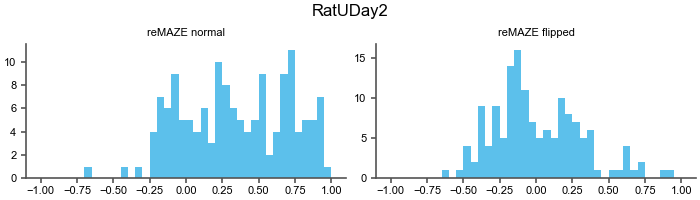

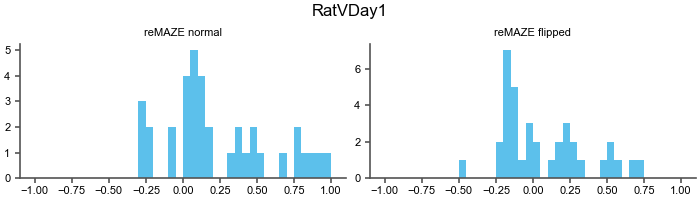

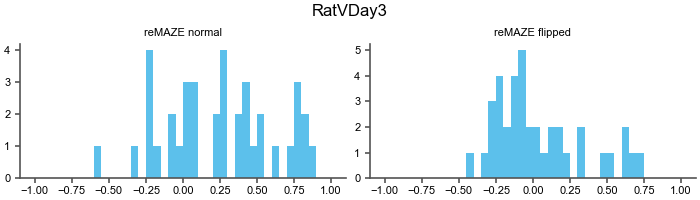

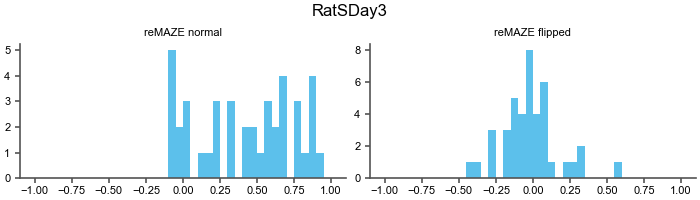

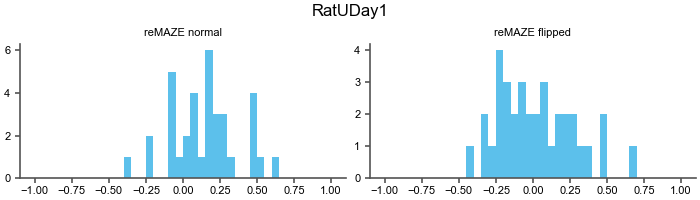

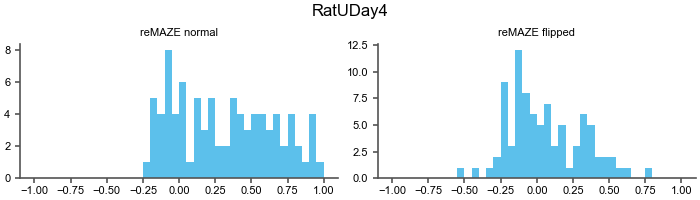

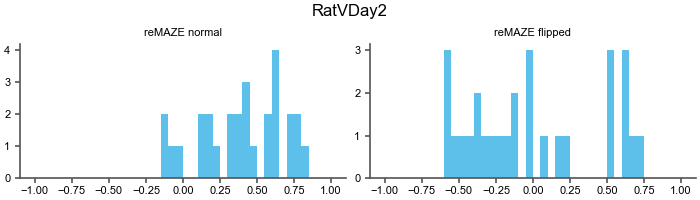

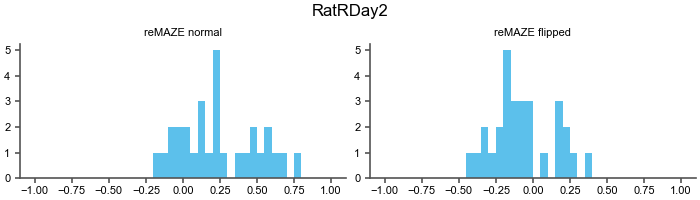

In [487]:
# There is no flipping of direction of fields / coherent rotations occurring in any session
binsize = 0.05
for name in pfcorr_by_dir.keys():
    fig, ax = plt.subplots(1, 2, figsize=(7, 2))
    fig.suptitle(name)
    
    ax[0].hist(pfcorr_by_dir[name]["remaze_same"], bins=np.arange(-1, 1.02, binsize))
    ax[0].set_title("reMAZE normal")

    ax[1].hist(pfcorr_by_dir[name]["remaze_flipped"], bins=np.arange(-1, 1.02, binsize))
    ax[1].set_title("reMAZE flipped")
    

/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Doc

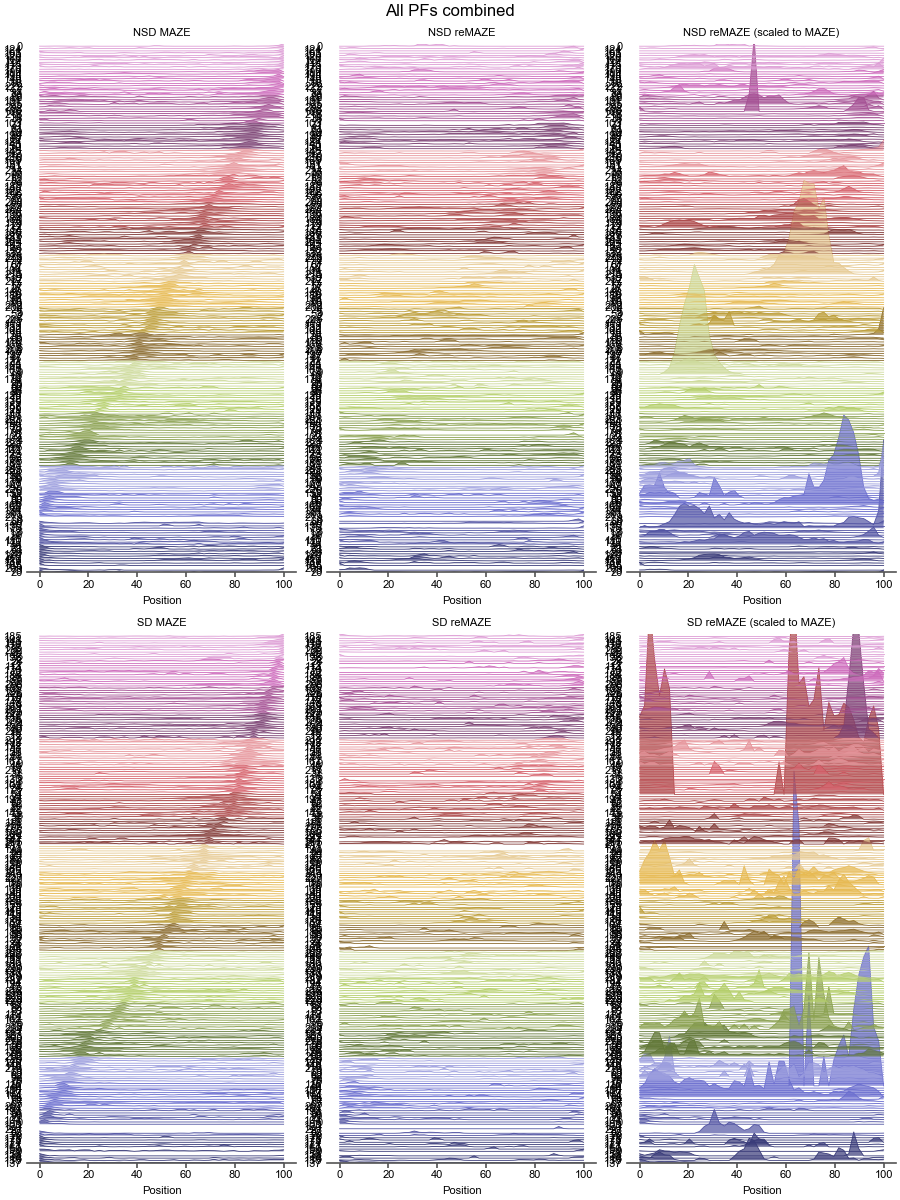

In [302]:
fig = Fig(nrows=2, ncols=3, size=(9, 12))
for idg, grp in enumerate(["NSD" , "SD"]):
    pfmazeall = deepcopy(pfmaze)
    pfmazeall.tuning_curves = tc_all.iloc[np.where(tc_all.grp == grp)[0], 0:50]
    pfmazeall.neuron_ids = np.arange(pfmazeall.tuning_curves.shape[0])
    pfmazeall.coords = np.linspace(0, 100, 50)
    
    pfremazeall = deepcopy(pfremaze)
    pfremazeall.tuning_curves = tc_all.iloc[np.where(tc_all.grp == grp)[0], 50:100]
    pfremazeall.neuron_ids = np.arange(pfremazeall.tuning_curves.shape[0])
    pfremazeall.coords = np.linspace(0, 100, 50)

    # Now plot place fields for each session individually as a sanity check
    maze_min = np.min(pfmazeall.tuning_curves, axis=1)[:, None]
    maze_ptp = np.ptp(pfmazeall.tuning_curves, axis=1)[:, None]
    remaze_pfall_scaled = min_max_external_scaler(pfremazeall.tuning_curves, maze_min, maze_ptp)
    pfremazeall_scaled = deepcopy(pfremazeall)
    pfremazeall_scaled.tuning_curves = remaze_pfall_scaled
    
    fig.fig.suptitle("All PFs combined")
    axmaze = fig.subplot(fig.gs[idg, 0])
    axremaze = fig.subplot(fig.gs[idg, 1])
    axremaze_scaled = fig.subplot(fig.gs[idg, 2])
    sort_ind = np.argsort(np.argmax(pfmazeall.tuning_curves, axis=1))
    plot_ratemap(pfmazeall, normalize_tuning_curve=True, sortby=sort_ind, ax=axmaze)
    axmaze.set_title(f'{grp} MAZE')
    plot_ratemap(pfremazeall, normalize_tuning_curve=True, sortby=sort_ind, ax=axremaze, pad=1)
    axremaze.set_title(f'{grp} reMAZE')
    plot_ratemap(pfremazeall_scaled, normalize_tuning_curve=False, sortby=sort_ind, ax=axremaze_scaled, pad=1)
    axremaze_scaled.set_title(f'{grp} reMAZE (scaled to MAZE)')
run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
fig.savefig(plot_dir / f"All_pfs_{run_flag}.pdf")

In [150]:
tc_all

0         1         2         3         4         5          6  \
0    0.231656  0.114982  0.409345  0.627248  0.660590  0.467383   0.140706   
1    0.347485  0.585747  0.128275  0.087834  0.088352  0.060821   0.043096   
2    1.969080  2.136531  1.608658  1.341657  0.658252  0.455159   0.442283   
3    4.980613  2.703945  0.900379  0.323498  0.321895  0.183269   0.103201   
4    6.833865  4.631787  2.482742  2.123533  2.858185  4.456214  10.947153   
..        ...       ...       ...       ...       ...       ...        ...   
456  0.000000  0.082379  0.036203  0.014939  0.020504  0.000000   0.020498   
457  4.009948  2.276459  2.502884  2.314180  3.025270  1.311594   1.211578   
458  0.000000  0.041065  0.034973  0.025902  0.017516  0.020605   0.000000   
459  0.200497  0.658612  0.542350  0.386520  0.579119  1.482241   1.583281   
460  0.000000  0.041065  0.023455  0.030881  0.019010  0.000000   0.020498   

             7          8          9  ...        92        93        94  \
0     0.000000   0.000000   0.000000  ...  0.000000  0.000000  0.010992   
1     0.016895   0.000000   0.000000  ...  0.000000  0.000000  0.021984   
2     0.364417   0.378815   0.602563  ...  0.352097  0.565040  0.495247   
3     0.141444   0.152760   0.105758  ...  0.098376  0.075106  0.065254   
4    15.305053  17.457245  18.670325  ...  0.952707  1.048000  1.308560   
..         ...        ...        ...  ...       ...       ...       ...   
456   0.030585   0.000000   0.000000  ...  6.285530  3.822165  2.060313   
457   1.394985   1.642056   2.742996  ...  4.031576  5.720799  4.512161   
458   0.180080   0.128828   0.064387  ...  0.000000  0.000000  0.021672   
459   2.281944   1.923528   2.102187  ...  0.000000  0.000000  0.000000   
460   0.034464   0.108877   0.204814  ...  0.000000  0.000000  0.000000   

           95        96        97        98        99  session  grp  
0    0.081826  0.337582  0.650193  0.000000  0.000000        0  NSD  
1    0.046071  0.027190  0.030058  0.081996  0.000000        0  NSD  
2    0.699526  1.110239  0.919810  0.819962  0.000000        0  NSD  
3    0.046071  0.027190  0.015481  0.000000  0.000000        0  NSD  
4    1.710390  2.073164  2.750394  3.279849  0.000000        0  NSD  
..        ...       ...       ...       ...       ...      ...  ...  
456  2.406967  2.229448  0.797890  0.150395  0.187790        7   SD  
457  2.633325  4.746292  4.816492  1.763489  2.159587        7   SD  
458  0.291266  0.039010  0.013597  0.010974  0.281685        7   SD  
459  0.000000  0.383251  1.285219  5.649736  1.314531        7   SD  
460  0.000000  0.000000  0.006955  0.012533  0.000000        7   SD  

[461 rows x 102 columns]

In [798]:
use_same_peak_bin = True
exclude_bad_sd = False
tc_all_use = tc_all[~((tc_all.session == 4) | (tc_all.session == 5))] if exclude_bad_sd else tc_all
corrs = tc_all_use.drop(columns=["session", "grp"]).apply(pf_corr_maze_remaze, axis=1)
delta_rate_ind = tc_all_use.drop(columns=["session", "grp"]).apply(delta_rate_index, axis=1, use_same_peak_bin=use_same_peak_bin).abs()
delta_peak_bin = tc_all_use.drop(columns=["session", "grp"]).apply(delta_pf_peak, axis=1).abs()
pf_loc = tc_all_use.drop(columns=["grp" ,"session"]).apply(get_pf_loc, axis=1)

tc_new_df = deepcopy(tc_all_use)
tc_new_df["PF Corr"] = corrs.values
tc_new_df["Delta_rate_index"] = delta_rate_ind.values
tc_new_df["Delta_peak_bin"] = delta_peak_bin.values
tc_new_df["PF_pos"] = pf_loc
tc_new_df["comp"] = 1

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/1866033896.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return (maze_max - remaze_max) / (maze_max + remaze_max)


<Axes: xlabel='PF_pos', ylabel='PF Corr'>

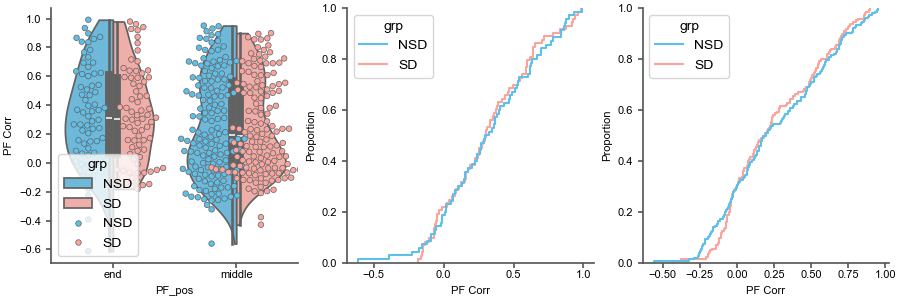

In [796]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
sns.violinplot(data=tc_new_df, x="PF_pos", y="PF Corr", hue="grp", split=True, cut=0, ax=ax[0])
sns.ecdfplot(data=tc_new_df[tc_new_df.PF_pos == "end"], x="PF Corr", hue="grp", ax=ax[1])
sns.ecdfplot(data=tc_new_df[tc_new_df.PF_pos == "middle"], x="PF Corr", hue="grp", ax=ax[2])
sns.swarmplot(data=tc_new_df, x="PF_pos", y="PF Corr", hue="grp", size=4, linewidth=0.5, dodge=True, ax=ax[0])
# fig.savefig(plot_dir / f"PFcorrs_by_section2_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [676]:
tc_new_df.grp

0      NSD
1      NSD
2      NSD
3      NSD
4      NSD
      ... 
456     SD
457     SD
458     SD
459     SD
460     SD
Name: grp, Length: 461, dtype: object

In [729]:
import pingouin as pg
pfpos = "end"
df_nsd = tc_new_df[tc_new_df.grp == "NSD"]
df_nsd = df_nsd[df_nsd["PF_pos"] == pfpos] if pfpos is not None else df_nsd
df_sd = tc_new_df[tc_new_df.grp == "SD"]
df_sd = df_sd[df_sd["PF_pos"] == pfpos] if pfpos is not None else df_sd
metric = "PF Corr"
stats = pg.mwu(df_nsd[metric], df_sd[metric], alternative="two-sided")
stats

U-val alternative     p-val       RBC      CLES
MWU  2698.0   two-sided  0.408437  0.077607  0.461197

In [714]:
from scipy.stats import kstest
print(kstest(df_nsd[metric], df_sd[metric], alternative="greater"))

KstestResult(statistic=0.09153687922421393, pvalue=0.4598272234267305, statistic_location=17, statistic_sign=1)


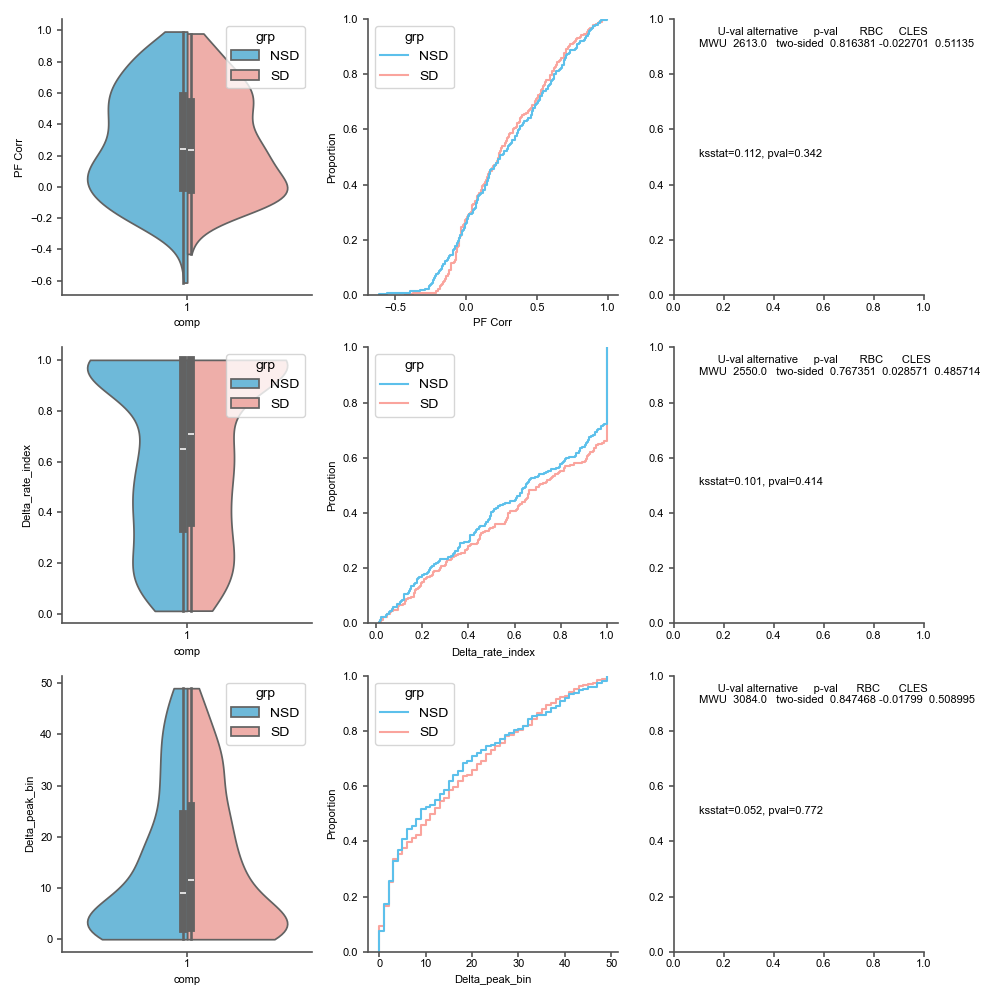

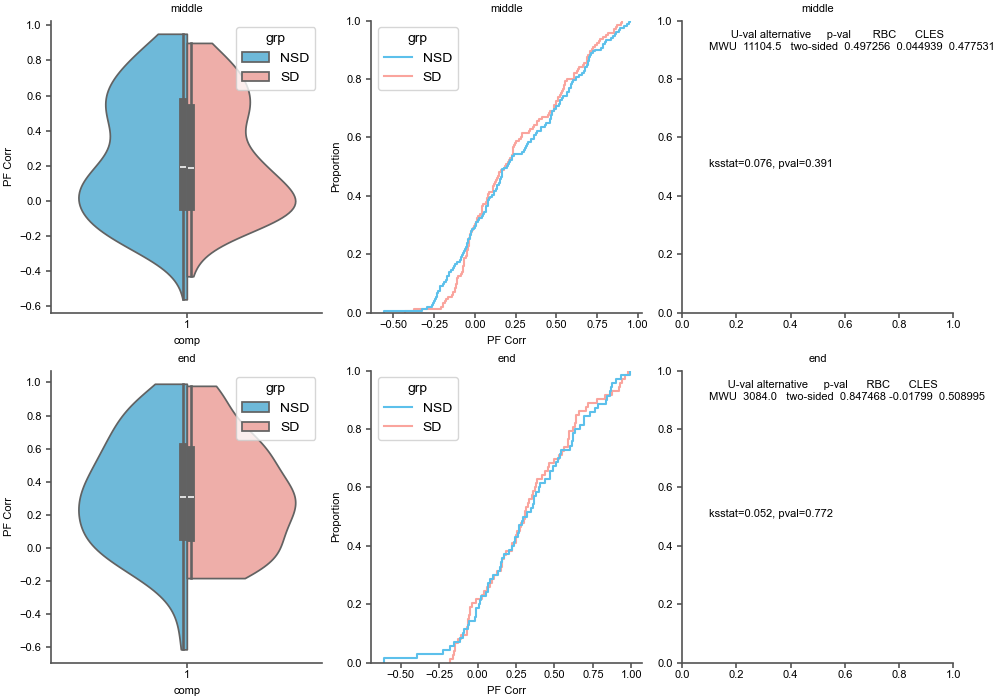

In [799]:
figpf_stats, axs = plt.subplots(3, 3, figsize=(10, 10), layout='tight')

pos = None
for metric, ax in zip(["PF Corr", "Delta_rate_index", "Delta_peak_bin"], axs):
    sns.violinplot(data=tc_new_df, x="comp", y=metric, hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=tc_new_df, x=metric, hue="grp", ax=ax[1])

    # Stats
    df_nsd = tc_new_df[tc_new_df.grp == "NSD"]
    df_nsd = df_nsd[df_nsd["PF_pos"] == pfpos] if pfpos is not None else df_nsd
    df_sd = tc_new_df[tc_new_df.grp == "SD"]
    df_sd = df_sd[df_sd["PF_pos"] == pfpos] if pfpos is not None else df_sd
    stats = pg.mwu(df_nsd[metric], df_sd[metric], alternative="two-sided")
    ax[2].text(0.1, 0.9, stats, fontsize=8)
    
    ksstat = kstest(df_nsd[metric], df_sd[metric], alternative="greater")
    ax[2].text(0.1, 0.5, f"ksstat={ksstat.statistic:.3f}, pval={ksstat.pvalue:.3f}", fontsize=8)
    
run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
figpf_stats.savefig(plot_dir / f"PFcorrs_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

figpf_stats2, axs_split = plt.subplots(2, 3, figsize=(10, 7))
for pos, ax in zip(["middle", "end"], axs_split):
    df_use = tc_new_df[tc_new_df.PF_pos == pos]
    sns.violinplot(data=df_use, x="comp", y="PF Corr", hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=df_use, x="PF Corr", hue="grp", ax=ax[1])
    [a.set_title(pos) for a in ax];

    # Stats
    df_nsd = df_use[df_use.grp == "NSD"]
    df_sd = df_use[df_use.grp == "SD"]
    stats = pg.mwu(df_nsd[metric], df_sd[metric], alternative="two-sided")
    ax[2].text(0.1, 0.9, stats, fontsize=8)
    
    ksstat = kstest(df_nsd[metric], df_sd[metric], alternative="greater")
    ax[2].text(0.1, 0.5, f"ksstat={ksstat.statistic:.3f}, pval={ksstat.pvalue:.3f}", fontsize=8)
    
figpf_stats2.savefig(plot_dir / f"PFcorrs_by_section_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [152]:
corrs

0     -0.156354
1      0.237798
2      0.443786
3      0.960345
4      0.782548
         ...   
456    0.574307
457    0.225998
458    0.248330
459    0.384213
460    0.114526
Length: 461, dtype: float64

In [144]:
tc_all

0         1         2         3         4         5          6  \
0    0.231656  0.114982  0.409345  0.627248  0.660590  0.467383   0.140706   
1    0.347485  0.585747  0.128275  0.087834  0.088352  0.060821   0.043096   
2    1.969080  2.136531  1.608658  1.341657  0.658252  0.455159   0.442283   
3    4.980613  2.703945  0.900379  0.323498  0.321895  0.183269   0.103201   
4    6.833865  4.631787  2.482742  2.123533  2.858185  4.456214  10.947153   
..        ...       ...       ...       ...       ...       ...        ...   
456  0.000000  0.082379  0.036203  0.014939  0.020504  0.000000   0.020498   
457  4.009948  2.276459  2.502884  2.314180  3.025270  1.311594   1.211578   
458  0.000000  0.041065  0.034973  0.025902  0.017516  0.020605   0.000000   
459  0.200497  0.658612  0.542350  0.386520  0.579119  1.482241   1.583281   
460  0.000000  0.041065  0.023455  0.030881  0.019010  0.000000   0.020498   

             7          8          9  ...        92        93        94  \
0     0.000000   0.000000   0.000000  ...  0.000000  0.000000  0.010992   
1     0.016895   0.000000   0.000000  ...  0.000000  0.000000  0.021984   
2     0.364417   0.378815   0.602563  ...  0.352097  0.565040  0.495247   
3     0.141444   0.152760   0.105758  ...  0.098376  0.075106  0.065254   
4    15.305053  17.457245  18.670325  ...  0.952707  1.048000  1.308560   
..         ...        ...        ...  ...       ...       ...       ...   
456   0.030585   0.000000   0.000000  ...  6.285530  3.822165  2.060313   
457   1.394985   1.642056   2.742996  ...  4.031576  5.720799  4.512161   
458   0.180080   0.128828   0.064387  ...  0.000000  0.000000  0.021672   
459   2.281944   1.923528   2.102187  ...  0.000000  0.000000  0.000000   
460   0.034464   0.108877   0.204814  ...  0.000000  0.000000  0.000000   

           95        96        97        98        99  session  grp  
0    0.081826  0.337582  0.650193  0.000000  0.000000        0  NSD  
1    0.046071  0.027190  0.030058  0.081996  0.000000        0  NSD  
2    0.699526  1.110239  0.919810  0.819962  0.000000        0  NSD  
3    0.046071  0.027190  0.015481  0.000000  0.000000        0  NSD  
4    1.710390  2.073164  2.750394  3.279849  0.000000        0  NSD  
..        ...       ...       ...       ...       ...      ...  ...  
456  2.406967  2.229448  0.797890  0.150395  0.187790        7   SD  
457  2.633325  4.746292  4.816492  1.763489  2.159587        7   SD  
458  0.291266  0.039010  0.013597  0.010974  0.281685        7   SD  
459  0.000000  0.383251  1.285219  5.649736  1.314531        7   SD  
460  0.000000  0.000000  0.006955  0.012533  0.000000        7   SD  

[461 rows x 102 columns]

In [92]:
pfmaze.tuning_curves.shape

(302, 47)

In [98]:
np.concatenate((pfmaze.neuron_ids, pfmaze.neuron_ids * -1), axis=0)

array([   7,    9,   11,   13,   15,   17,   19,   21,   26,   28,   29,
         31,   34,   38,   41,   44,   46,   49,   51,   53,   54,   55,
         56,   57,   59,   60,   61,   62,   63,   65,   68,   69,   72,
         74,   81,   82,   85,   86,   87,   92,   93,   94,   95,  100,
        101,  102,  105,  107,  108,  110,  111,  115,  124,  126,  129,
        130,  131,  132,  134,  135,  137,  140,  147,  151,  152,  153,
        154,  156,  157,  159,  160,  161,  164,  168,  170,  175,  177,
        179,  184,  185,  189,  190,  191,  192,  194,  196,  197,  198,
        199,  200,  201,  204,  205,  206,  207,  208,  210,  211,  212,
        213,  214,  216,  217,  218,  220,  221,  222,  223,  226,  228,
        230,  231,  232,  233,  234,  235,  237,  238,  239,  240,  241,
        242,  243,  244,  245,  246,  250,  251,  252,  253,  254,  255,
        256,  258,  259,  264,  265,  268,  269,  270,  271,  272,  273,
        275,  276,  278,  281,  283,  285,  286,  2

In [93]:
pfremaze.tuning_curves.shape

(302, 46)

/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp


In [57]:

maze_min = np.min(pfmaze.tuning_curves, axis=1)[:, None]
maze_ptp = np.ptp(pfmaze.tuning_curves, axis=1)[:, None]
remaze_pf_scaled = min_max_external_scaler(pfremaze.tuning_curves, maze_min, maze_ptp)
pfremaze_scaled = deepcopy(pfremaze)
pfremaze_scaled.tuning_curves = remaze_pf_scaled

/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp


In [495]:
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
fig = Fig(num=f"{sess.name}{sess.tag}", nrows=1, ncols=3, size=(9, 8))
fig.fig.suptitle(f"{sess.name}{sess.tag}")
axmaze = fig.subplot(fig.gs[0])
axremaze = fig.subplot(fig.gs[1])
axremaze_scaled = fig.subplot(fig.gs[2])
sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axmaze)
axmaze.set_title('MAZE')
plot_ratemap(pfremaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axremaze, pad=1)
axremaze.set_title('reMAZE')
plot_ratemap(pfremaze_scaled, normalize_tuning_curve=False, sortby=sort_ind, ax=axremaze_scaled, pad=1)
axremaze_scaled.set_title('reMAZE (scaled to MAZE)')
fig.savefig(plot_dir / "test.pdf")

/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


In [498]:
pfmaze_slice = pfmaze.neuron_slice([1, 5, 10])

In [507]:
pfmaze_slice.neuron_ids

array([ 3, 10, 19])

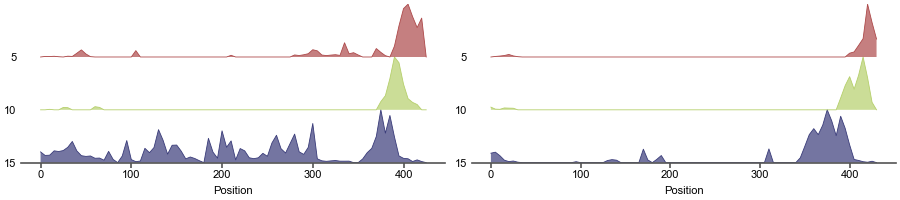

In [741]:
slice = [5, 10, 15]
test = pfmaze.neuron_slice(ids=slice)
test2 = pfremaze.neuron_slice(ids=slice)
figpfex, ax = plt.subplots(1, 2, figsize=(9, 2))
plot_ratemap(test, normalize_tuning_curve=True, ax=ax[0])
plot_ratemap(test2, normalize_tuning_curve=True, ax=ax[1])
figpfex.savefig(plot_dir / "pfexamples_for_metrics.pdf")

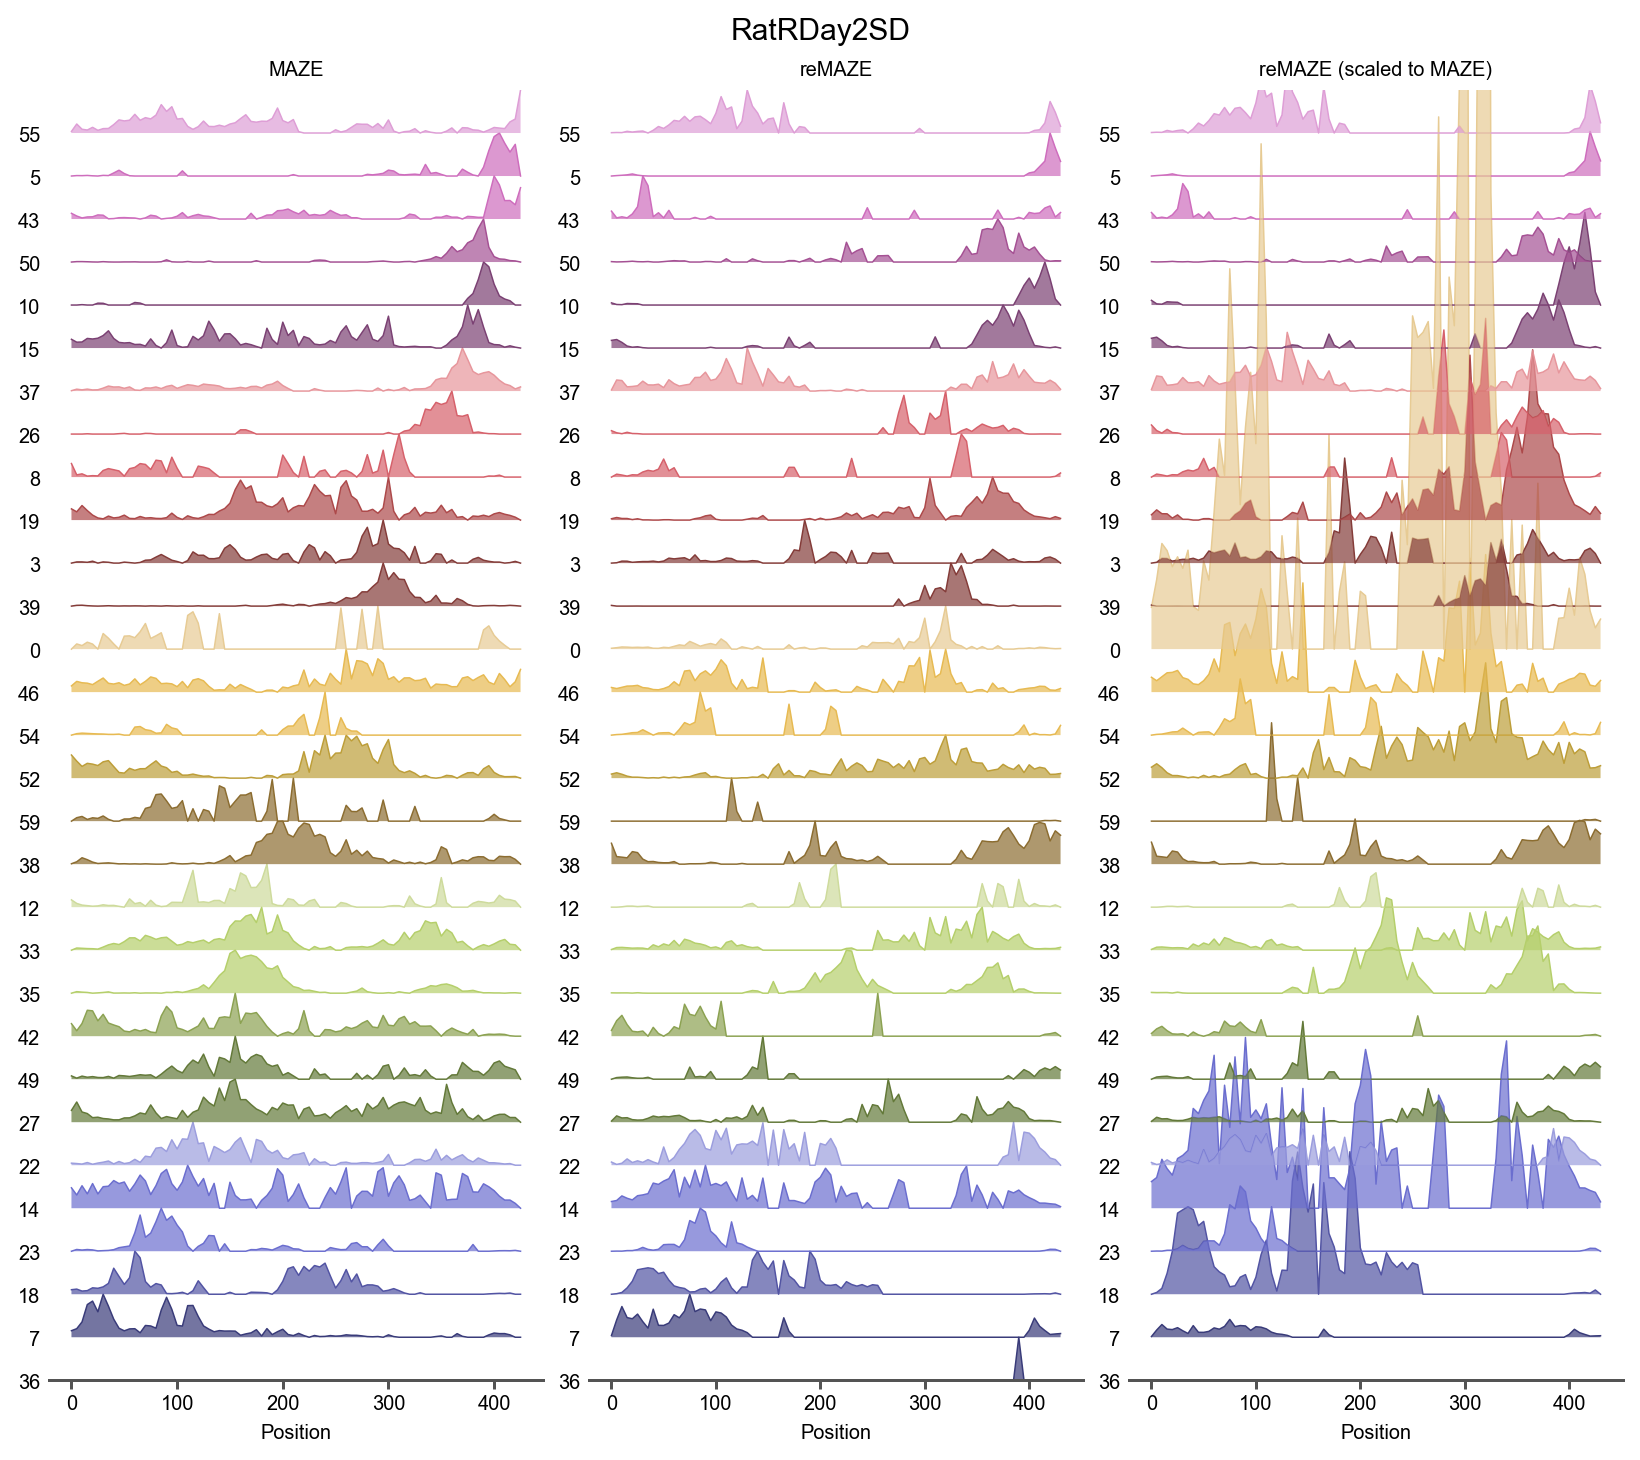

In [496]:
fig.fig

In [810]:
from neuropy.utils.mathutil import min_max_external_scaler
m

In [812]:
maze_ptp = np.ptp(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
maze_min = np.min(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
min_max_external_scaler(tc_grp[:, :nbins_per_sesh], maze_min, maze_ptp)

/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp


array([[0.4485931 , 1.        , 0.44990771, ..., 0.0179278 , 0.        ,
        0.        ],
       [0.        , 0.24864748, 0.22254751, ..., 0.29660932, 0.36864403,
        0.        ],
       [0.02548977, 0.00705007, 0.00805983, ..., 0.08803742, 0.61431454,
        0.        ],
       ...,
       [0.        , 0.12010579, 0.08331457, ..., 0.        , 0.        ,
        0.        ],
       [0.04299944, 0.16241914, 0.141728  , ..., 0.11658944, 0.30252885,
        1.        ],
       [0.        , 0.16037279, 0.05789189, ..., 0.05876215, 0.        ,
        0.        ]])

### Plot individual PFs and PV correlations across MAZE-reMAZE

/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp
/Users/nkinsky/Documents/UM/GitHub/NeuroPy/neuropy/utils/mathutil.py:87: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp


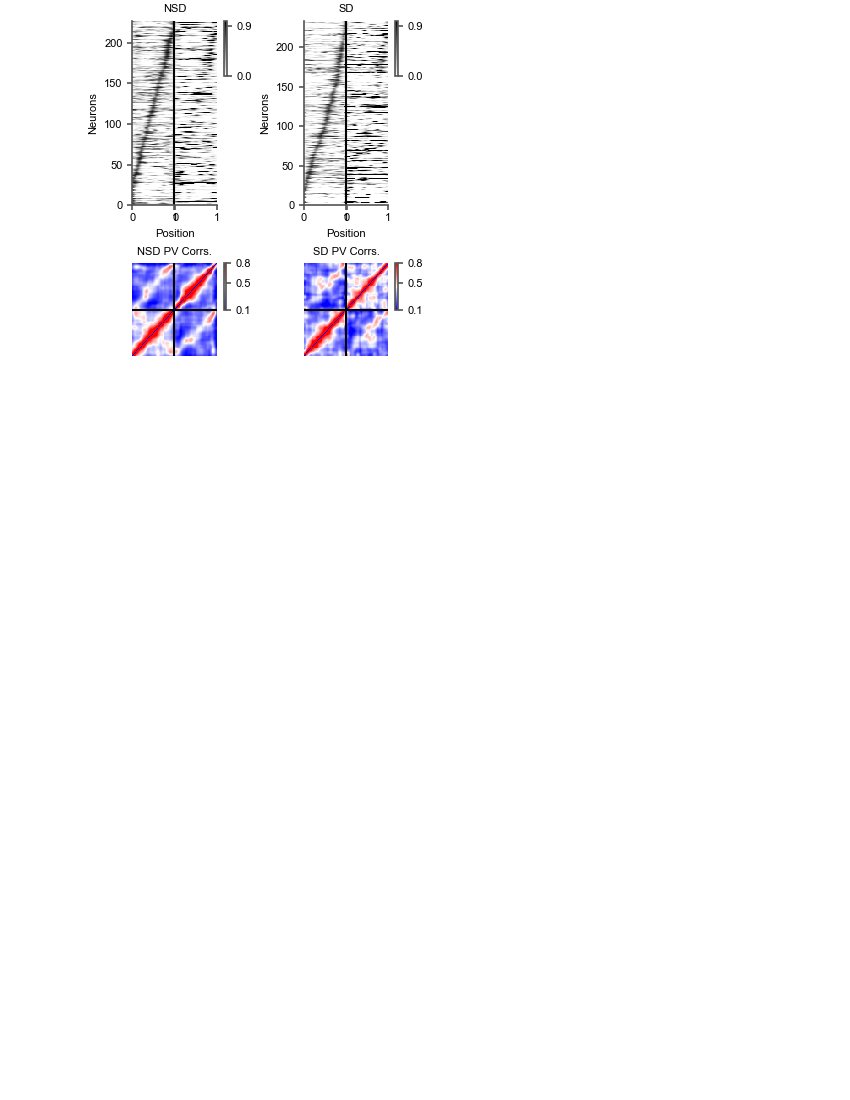

In [840]:
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

fig = plotting.Fig(11, 8)

exclude_nan = False
sort_by = "MAZE"
scale_row_method = "maze" # scales activity together or by each maze individually
assert scale_row_method in ["by_maze", "maze", "all"]
assert sort_by in ["MAZE", "reMAZE"]
corr_all, tc_new_all = [], []
for g, grp in enumerate(["NSD", "SD"]):

    # Grab place field firing as a numpy array
    tc_grp = tc_all[tc_all.grp == grp].drop(columns=["session", "grp"]).to_numpy()
    # tc_grp = gaussian_filter1d(tc_grp, sigma=1.5, axis=1)
    assert (nbins_per_sesh := int(tc_grp.shape[1]/2)) == tc_grp.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"
    
    # Scale each row to its peak firing rate
    tc_new = np.zeros_like(tc_grp)
    if scale_row_method == "by_maze":
        tc_new[:, :nbins_per_sesh] = min_max_scaler(tc_grp[:, :nbins_per_sesh], axis=1)
        tc_new[:, nbins_per_sesh:] = min_max_scaler(tc_grp[:, nbins_per_sesh:], axis=1)
    elif scale_row_method == "all":
        tc_new = min_max_scaler(tc_grp, axis=1)
        print('test')
        # tc_new =  min_max_scaler(tc_grp,axis=-1)
    elif scale_row_method == "maze":
        maze_ptp = np.ptp(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        maze_min = np.min(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        tc_new[:, :nbins_per_sesh] = min_max_external_scaler(tc_grp[:, :nbins_per_sesh], maze_min, maze_ptp)
        tc_new[:, nbins_per_sesh:] = min_max_external_scaler(tc_grp[:, nbins_per_sesh:], maze_min, maze_ptp)
        

    # Sort by MAZE or reMAZE
    if sort_by == "MAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, :nbins_per_sesh], axis=1))
    elif sort_by == "reMAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, nbins_per_sesh:], axis=1))
    tc_new = gaussian_filter1d(tc_new, sigma=1.5, axis=1)
    tc_new_df = pd.DataFrame(tc_new[sort_ind])
    tc_new_df["session"] = tc_all[tc_all.grp == grp].session.values[sort_ind]
    tc_new_df["grp"] = grp
    tc_new_all.append(tc_new_df)
    # print(tc_new.shape)

    # Plot place fields
    ax = fig.subplot(fig.gs[:2, g + 1])
    ax.set_title(grp)
    pf_plot = tc_new[sort_ind, :]
    pf_plot = pf_plot[~np.any(np.isnan(pf_plot), axis=1)] if exclude_nan else pf_plot
    pf_im = ax.pcolormesh(pf_plot, cmap="binary", rasterized=True, vmin=0, vmax=1)
    ax.axvline(nbins_per_sesh, color="k")
    ax.set_xticks([0, nbins_per_sesh, nbins_per_sesh + 1, nbins_per_sesh * 2], [0, 1, 0, 1])
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Position")
    pf_cb = plt.colorbar(pf_im, anchor=(1, 1), shrink=0.3, ticks=[0, 0.9])

    # Plot PV correlations
    ax = fig.subplot(fig.gs[2, g + 1])
    ax.set_title(f"{grp} PV Corrs.")
    corr = gaussian_filter(np.corrcoef(tc_grp.T), 1)
    # corr = np.corrcoef(tc_grp.T)
    np.fill_diagonal(corr, 0)
    corr_all.append(corr)
    corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
    ax.axvline(nbins_per_sesh, color="k")
    ax.axhline(nbins_per_sesh, color="k")
    ax.axis("off")
    corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
fig.savefig(plot_dir / f"maze_remaze_pf_corrs_{sort_by}sorted_{run_flag}.pdf")

In [330]:
remaze_test.reshape(-1).sum()

1130.5148301576892

In [411]:
def mean_of_rotated_array(rot_array, nan_ctr=True):
    sums = rot_array.sum(axis=0)
    denom = (rot_array != 0).sum(axis=0)

    if nan_ctr:
        sums[np.floor(sums.shape[0]/2 - 0.5).astype(int):np.ceil(sums.shape[0]/2 + 0.5).astype(int)] = np.nan

    return sums / denom
mean_of_rotated_array(maze_test_rotate)

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/4081999875.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom


array([       nan, 0.35719059, 0.25663086, 0.20541095, 0.19583491,
       0.21359307, 0.22789862, 0.2291391 , 0.21907624, 0.20498629,
       0.18996928, 0.17754782, 0.16995799, 0.16705652, 0.16849632,
       0.17325392, 0.17921215, 0.18313335, 0.18576594, 0.19108405,
       0.20055723, 0.21155667, 0.22360531, 0.23888175, 0.25876493,
       0.28228266, 0.30927556, 0.33898827, 0.37142006, 0.41123066,
       0.46437719, 0.53786018, 0.63416159, 0.71476692, 0.95798079,
              nan, 0.95798079, 0.71476692, 0.63416159, 0.53786018,
       0.46437719, 0.41123066, 0.37142006, 0.33898827, 0.30927556,
       0.28228266, 0.25876493, 0.23888175, 0.22360531, 0.21155667,
       0.20055723, 0.19108405, 0.18576594, 0.18313335, 0.17921215,
       0.17325392, 0.16849632, 0.16705652, 0.16995799, 0.17754782,
       0.18996928, 0.20498629, 0.21907624, 0.2291391 , 0.22789862,
       0.21359307, 0.19583491, 0.20541095, 0.25663086, 0.35719059,
              nan])

In [410]:
t = np.array([0, 1, 2, 3, 4, 5, 6, 7]).astype(float)
t[np.floor(t.shape[0]/2 - 0.5).astype(int):np.ceil(t.shape[0]/2 + 0.5).astype(int)] = np.nan
t

array([ 0.,  1.,  2., nan, nan,  5.,  6.,  7.])

In [338]:
(maze_test_rotate != 0).sum(axis=0)

array([ 0,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31,
       33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65,
       67, 69, 67, 65, 63, 61, 59, 57, 55, 53, 51, 49, 47, 45, 43, 41, 39,
       37, 35, 33, 31, 29, 27, 25, 23, 21, 19, 17, 15, 13, 11,  9,  7,  5,
        3,  1,  0])

In [335]:
maze_test_rotate.mean(axis=0)

array([0.        , 0.00613696, 0.01567309, 0.02461528, 0.03388839,
       0.04450039, 0.05461238, 0.06281942, 0.06983066, 0.07678457,
       0.08340882, 0.08927458, 0.09594589, 0.10464797, 0.11499433,
       0.12582447, 0.13712506, 0.14889367, 0.16101414, 0.1756195 ,
       0.19281099, 0.21047812, 0.22875774, 0.2493604 , 0.273357  ,
       0.3003541 , 0.331307  , 0.36637466, 0.40526505, 0.44952136,
       0.50157805, 0.5670697 , 0.64902123, 0.71381231, 0.93891779,
       0.11624161, 0.93891779, 0.71381231, 0.64902123, 0.5670697 ,
       0.50157805, 0.44952136, 0.40526505, 0.36637466, 0.331307  ,
       0.3003541 , 0.273357  , 0.2493604 , 0.22875774, 0.21047812,
       0.19281099, 0.1756195 , 0.16101414, 0.14889367, 0.13712506,
       0.12582447, 0.11499433, 0.10464797, 0.09594589, 0.08927458,
       0.08340882, 0.07678457, 0.06983066, 0.06281942, 0.05461238,
       0.04450039, 0.03388839, 0.02461528, 0.01567309, 0.00613696,
       0.        ])

### Plot place field width changes over time
Need to normalize before doing subtraction!

0.4343271266852196
0.3850317659839695


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/4081999875.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom


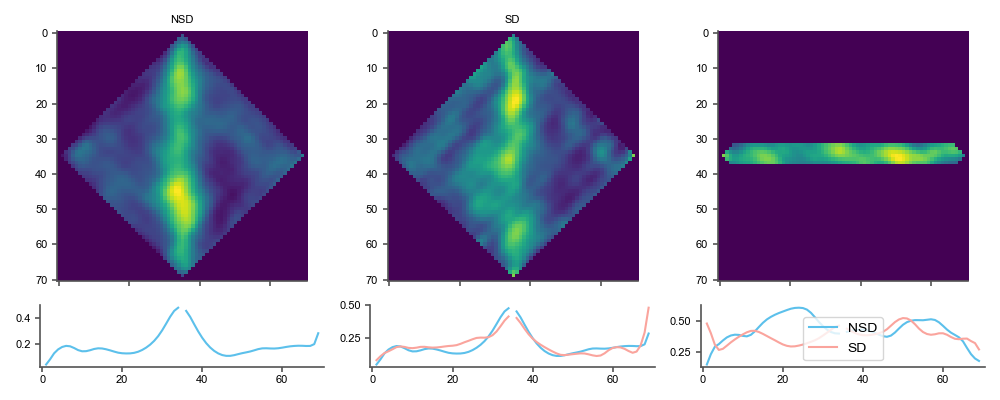

In [744]:
_, ax = plt.subplots(2, 3, figsize=(10, 4), height_ratios=[4, 1], sharex=True, layout='tight')
h_all = []
for idg, group in enumerate(["NSD", "SD"]):
    bw_test = corr_all[idg][0:50,50:100]
    bw_test_rot = rotate(bw_test, 135, reshape=True)
    bw_test_rot2 = rotate(bw_test, 45, reshape=True)
    bw_test_rot2[:32, :] = 0
    bw_test_rot2[38:, :] = 0
    # bw_test_rot2[32:38, :] = 0
    
    ax[0, idg].imshow(bw_test_rot)
    ax[0, idg].set_title(group)

    if idg == 0:
        ax[1, 1].plot(mean_of_rotated_array(bw_test_rot))
    ax[1, idg].plot(mean_of_rotated_array(bw_test_rot))

    htemp, = ax[1, 2].plot(mean_of_rotated_array(bw_test_rot2))
    print(np.nanmean(mean_of_rotated_array(bw_test_rot2)))
    h_all.append(htemp)

ax[0, 2].imshow(bw_test_rot2)
plt.legend(h_all, ["NSD", "SD"])

In [746]:
mean_of_rotated_array(remaze_test_rotate)

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/4081999875.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom


array([       nan, 0.15345041, 0.15788016, 0.18903618, 0.21670467,
       0.23501787, 0.24567648, 0.25295324, 0.25446042, 0.24172148,
       0.22486361, 0.21535677, 0.21803923, 0.22827614, 0.24225112,
       0.25215861, 0.25309366, 0.24826807, 0.24003876, 0.23197035,
       0.22867927, 0.23091267, 0.23866086, 0.24934716, 0.2616142 ,
       0.27732809, 0.29134676, 0.2995556 , 0.30703803, 0.31950764,
       0.3474637 , 0.40407275, 0.49183734, 0.57947429, 0.83303501,
              nan, 0.83303501, 0.57947429, 0.49183734, 0.40407275,
       0.3474637 , 0.31950764, 0.30703803, 0.2995556 , 0.29134676,
       0.27732809, 0.2616142 , 0.24934716, 0.23866086, 0.23091267,
       0.22867927, 0.23197035, 0.24003876, 0.24826807, 0.25309366,
       0.25215861, 0.24225112, 0.22827614, 0.21803923, 0.21535677,
       0.22486361, 0.24172148, 0.25446042, 0.25295324, 0.24567648,
       0.23501787, 0.21670467, 0.18903618, 0.15788016, 0.15345041,
              nan])

In [752]:
rotate_diff = remaze_test_rotate - maze_test_rotate
rotate_diff[rotate_diff == 0] = np.nan

In [768]:
np.arange(q_all.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70])

In [766]:
q_all = np.array(q_all)

In [763]:
# Calculate rough 95% CI for difference between curves
rotate_diff = remaze_test_rotate - maze_test_rotate
rotate_diff[rotate_diff == 0] = np.nan

q_all = []
for col in rotate_diff.T:
    if (~np.isnan(col)).sum() < 10:
        q_all.append([np.nan, np.nan])
    else:
        q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))

In [755]:
np.percentile(rotate_diff, q=[2.5, 97.5], axis=0)

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan]])

<Axes: >

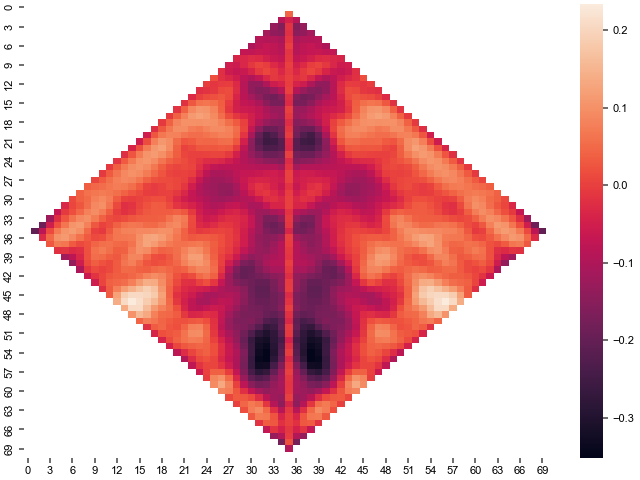

In [753]:
_, ax = plt.subplots()
sns.heatmap(rotate_diff)

In [775]:
np.arange(q_all.shape[0]).shape

(71,)

In [779]:
good_rows_bool = np.all(~np.isnan(q_all), axis=1)

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False])

In [781]:
xbins[good_rows_bool]

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64])

In [782]:
q_all[good_rows_bool, 0]

array([-0.22392332, -0.21361406, -0.19352267, -0.16718176, -0.17282576,
       -0.17180275, -0.15931376, -0.16093787, -0.19299089, -0.24313151,
       -0.2747806 , -0.27988264, -0.25940935, -0.21938688, -0.20315266,
       -0.21351003, -0.20936245, -0.19864127, -0.18881008, -0.19510394,
       -0.19874048, -0.20769842, -0.22855829, -0.25580278, -0.27760374,
       -0.29738432, -0.30003854, -0.27212464, -0.22986205, -0.0585579 ,
       -0.22986205, -0.27212464, -0.30003854, -0.29738432, -0.27760374,
       -0.25580278, -0.22855829, -0.20769842, -0.19874048, -0.19510394,
       -0.18881008, -0.19864127, -0.20936245, -0.21351003, -0.20315266,
       -0.21938688, -0.25940935, -0.27988264, -0.2747806 , -0.24313151,
       -0.19299089, -0.16093787, -0.15931376, -0.17180275, -0.17282576,
       -0.16718176, -0.19352267, -0.21361406, -0.22392332])

In [ ]:
_, ax = plt.subplots()
ax.fillb

In [784]:
q_all[good_rows_bool, 1]

array([-0.06739087, -0.06257915, -0.05855228, -0.05936235, -0.066222  ,
       -0.0810111 , -0.07319145, -0.08862199, -0.08543919, -0.0642099 ,
       -0.05466367, -0.05188006, -0.04686389, -0.04330917, -0.02677305,
       -0.02203358, -0.01529756,  0.0122766 ,  0.03311258,  0.05350644,
        0.06796855,  0.06350407,  0.04965336,  0.06543649,  0.07257554,
        0.05847128,  0.03235959,  0.03339921,  0.03067598,  0.01462676,
        0.03067598,  0.03339921,  0.03235959,  0.05847128,  0.07257554,
        0.06543649,  0.04965336,  0.06350407,  0.06796855,  0.05350644,
        0.03311258,  0.0122766 , -0.01529756, -0.02203358, -0.02677305,
       -0.04330917, -0.04686389, -0.05188006, -0.05466367, -0.0642099 ,
       -0.08543919, -0.08862199, -0.07319145, -0.0810111 , -0.066222  ,
       -0.05936235, -0.05855228, -0.06257915, -0.06739087])

In [792]:
hl[0].get_alpha()

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/4081999875.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/555304653.py:50: RuntimeWarning: Mean of empty slice
  rot_mean = np.nanmean(rotate_diff, axis=0)
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/4081999875.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/555304653.py:50: RuntimeWarning: M

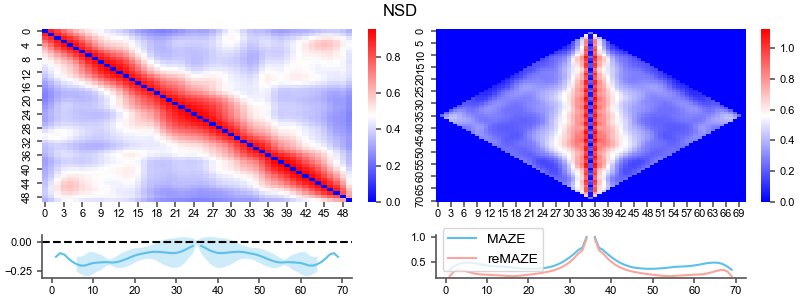

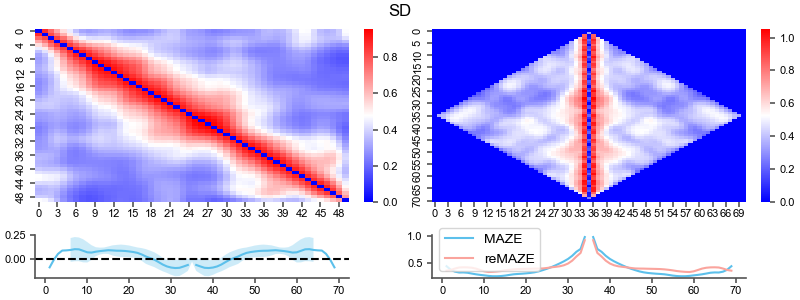

In [860]:
from scipy.ndimage import rotate

plt.rcParams["pdf.fonttype"] = 42
maze_rotate_all, remaze_rotate_all = [], []
for idg, group in enumerate(["NSD", "SD"]):
    fig, ax = plt.subplots(2, 2, figsize = (8, 3), height_ratios=[4, 1])
    # fig = plotting.Fig(11, 8)
    
    fig.suptitle(group)
    
    maze_test = corr_all[idg][0:50, 0:50]
    remaze_test = corr_all[idg][50:100, 50:100]
    sns.heatmap(maze_test, ax=ax[0][0], cmap="bwr")

    maze_test_rotate = rotate(maze_test, 135, reshape=True)
    remaze_test_rotate = rotate(remaze_test, 135, reshape=True)
    sns.heatmap(remaze_test_rotate, ax=ax[0][1], cmap="bwr")

    maze_rotate_all.append(maze_test_rotate)
    remaze_rotate_all.append(remaze_test_rotate)
    
    # hmaze, = ax[1][1].plot(maze_test_rotate.mean(axis=0))
    # hremaze, = ax[1][1].plot(remaze_test_rotate.mean(axis=0))

    # ax[1][0].plot(maze_test_rotate.mean(axis=0) - remaze_test_rotate.mean(axis=0))

    hmaze, = ax[1][1].plot(mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    hremaze, = ax[1][1].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True))

    hl = ax[1][0].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True) - mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    ax[1][0].axhline(0, linestyle="--", color="k")

    # Calculate rough 95% CI for difference between curves
    rotate_diff = remaze_test_rotate - maze_test_rotate
    rotate_diff[rotate_diff == 0] = np.nan

    # Go through each column to calculate 95% CI based on percentile
    q_all = []
    for col in rotate_diff.T:
        if (~np.isnan(col)).sum() < 10:
            q_all.append([np.nan, np.nan])
        else:
            q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))
    q_all = np.array(q_all)
    good_rows_bool = np.all(~np.isnan(q_all), axis=1)
    xbins = np.arange(q_all.shape[0])
    # ax[1][0].fill_between(xbins[good_rows_bool], q_all[good_rows_bool, 0], q_all[good_rows_bool, 1], alpha=0.3)

    rot_std = np.nanstd(rotate_diff, axis=0)
    rot_mean = np.nanmean(rotate_diff, axis=0)
    ax[1][0].fill_between(xbins[good_rows_bool], rot_mean[good_rows_bool] - rot_std[good_rows_bool], 
                          rot_mean[good_rows_bool] + rot_std[good_rows_bool], alpha=0.3)

    
    plt.legend((hmaze, hremaze), ["MAZE", "reMAZE"])
    fig.savefig(plot_dir / f"{group}_PVcorr_sharpening_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [851]:
rotate_diff.shape

(71, 71)

In [855]:
xbins[good_rows_bool] + rot_std[good_rows_bool]

array([ 6.04313393,  7.06588636,  8.09209233,  9.10712576, 10.09480191,
       11.0636801 , 12.04200342, 13.04829353, 14.06791679, 15.0965287 ,
       16.1145119 , 17.11236475, 18.0996118 , 19.08909208, 20.08654078,
       21.08915443, 22.09098589, 23.09644356, 24.10459185, 25.1135607 ,
       26.12291805, 27.12406403, 28.11917531, 29.1172516 , 30.11916337,
       31.11802961, 32.11229085, 33.09711424, 34.0802583 , 35.01317076,
       36.0802583 , 37.09711424, 38.11229085, 39.11802961, 40.11916337,
       41.1172516 , 42.11917531, 43.12406403, 44.12291805, 45.1135607 ,
       46.10459185, 47.09644356, 48.09098589, 49.08915443, 50.08654078,
       51.08909208, 52.0996118 , 53.11236475, 54.1145119 , 55.0965287 ,
       56.06791679, 57.04829353, 58.04200342, 59.0636801 , 60.09480191,
       61.10712576, 62.09209233, 63.06588636, 64.04313393])

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/4081999875.py:8: RuntimeWarning: invalid value encountered in divide
  return sums / denom
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_20569/3844007288.py:45: RuntimeWarning: Mean of empty slice
  rot_mean = np.nanmean(rotate_diff, axis=0)


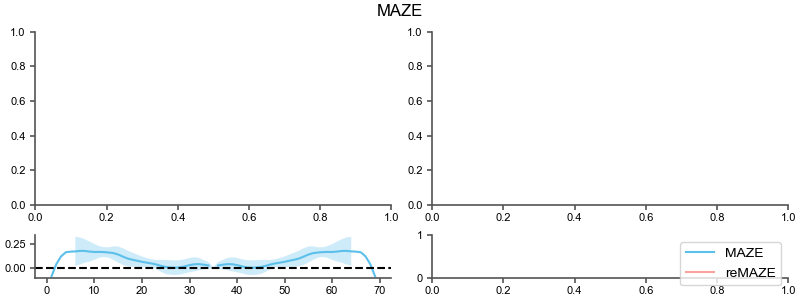

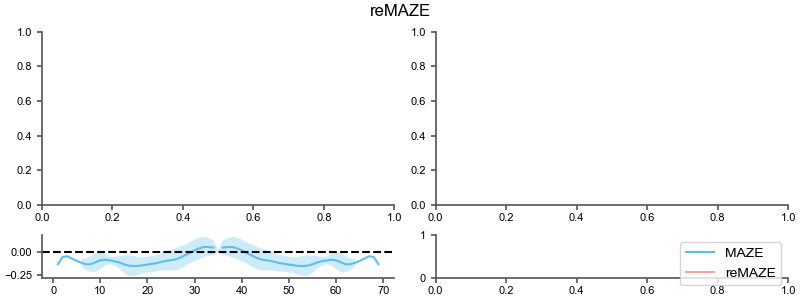

In [861]:
from scipy.ndimage import rotate

plt.rcParams["pdf.fonttype"] = 42
for idg, (mname, rot_arrays) in enumerate(zip(["MAZE", "reMAZE"], [maze_rotate_all, remaze_rotate_all])):
    fig, ax = plt.subplots(2, 2, figsize = (8, 3), height_ratios=[4, 1])
    # fig = plotting.Fig(11, 8)
    
    fig.suptitle(mname)
    
    # maze_test = corr_all[idg][0:50, 0:50]
    # remaze_test = corr_all[idg][50:100, 50:100]
    # sns.heatmap(maze_test, ax=ax[0][0], cmap="bwr")
    
    # maze_test_rotate = rotate(maze_test, 135, reshape=True)
    # remaze_test_rotate = rotate(remaze_test, 135, reshape=True)
    # sns.heatmap(remaze_test_rotate, ax=ax[0][1], cmap="bwr")
    
    # hmaze, = ax[1][1].plot(maze_test_rotate.mean(axis=0))
    # hremaze, = ax[1][1].plot(remaze_test_rotate.mean(axis=0))

    # ax[1][0].plot(maze_test_rotate.mean(axis=0) - remaze_test_rotate.mean(axis=0))

    # hmaze, = ax[1][1].plot(mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    # hremaze, = ax[1][1].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True))

    hl = ax[1][0].plot(mean_of_rotated_array(rot_arrays[0], nan_ctr=True) - mean_of_rotated_array(rot_arrays[1], nan_ctr=True))
    ax[1][0].axhline(0, linestyle="--", color="k")

    # Calculate rough 95% CI for difference between curves
    rotate_diff = rot_arrays[0] - rot_arrays[1]
    rotate_diff[rotate_diff == 0] = np.nan

    # Go through each column to calculate 95% CI based on percentile
    q_all = []
    for col in rotate_diff.T:
        if (~np.isnan(col)).sum() < 10:
            q_all.append([np.nan, np.nan])
        else:
            q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))
    q_all = np.array(q_all)
    good_rows_bool = np.all(~np.isnan(q_all), axis=1)
    xbins = np.arange(q_all.shape[0])
    # ax[1][0].fill_between(xbins[good_rows_bool], q_all[good_rows_bool, 0], q_all[good_rows_bool, 1], alpha=0.3)
    rot_std = np.nanstd(rotate_diff, axis=0)
    rot_mean = np.nanmean(rotate_diff, axis=0)
    ax[1][0].fill_between(xbins[good_rows_bool], rot_mean[good_rows_bool] - rot_std[good_rows_bool], 
                          rot_mean[good_rows_bool] + rot_std[good_rows_bool], alpha=0.3)

    
    plt.legend((hmaze, hremaze), ["MAZE", "reMAZE"])
    fig.savefig(plot_dir / f"{mname}_PVcorr_sharpening_by_maze_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

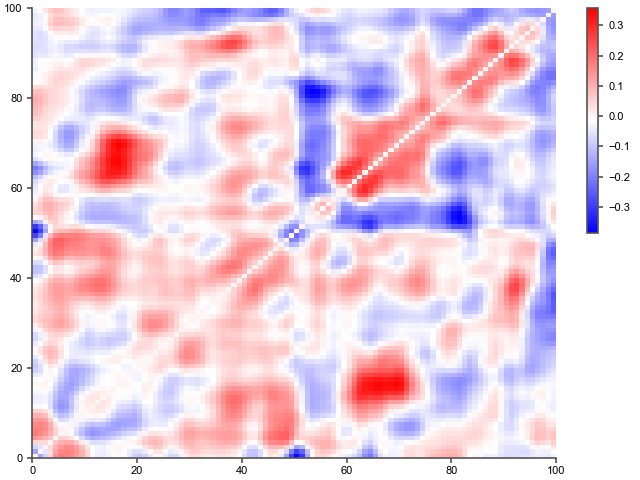

In [617]:
_, ax = plt.subplots()
corr_im = ax.pcolormesh(corr_all[0] - corr_all[1], cmap="bwr", rasterized=True)
corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1))

### Quantify PV correlations

Text(0.5, 1.0, 'nbins=2162')

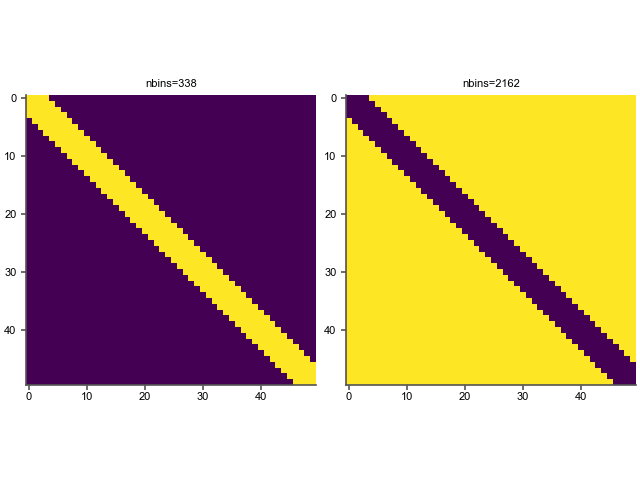

In [104]:
# Sanity check for plotting and calculating diagonal and off-diagonal values
t = np.ones((50, 50))
noffset = 3
_, ax = plt.subplots(1, 2)
t_diag = np.tril(np.triu(t, -noffset), noffset)
ax[0].imshow(t_diag)
ax[0].set_title(f"nbins={np.sum(t_diag.reshape(-1) != 0)}")
t_off = np.triu(t, noffset + 1) + np.tril(t, -noffset - 1)
ax[1].imshow(t_off)
ax[1].set_title(f"nbins={np.sum(t_off.reshape(-1) != 0)}")

NSD Off diagonal corrs = [0.3306325048041607, 0.1829719575199008, 0.1829719575199008, 0.2185389960628285]
NSD On diagonal corrs = [0.8258941732053255, 0.44568222535986035, 0.44568222535986035, 0.7697744124961617]
SD Off diagonal corrs = [0.2961950827340916, 0.19393287588969366, 0.19393287588969366, 0.2795274399590834]
SD On diagonal corrs = [0.8044136006157208, 0.39512673000081944, 0.39512673000081944, 0.680816789541048]


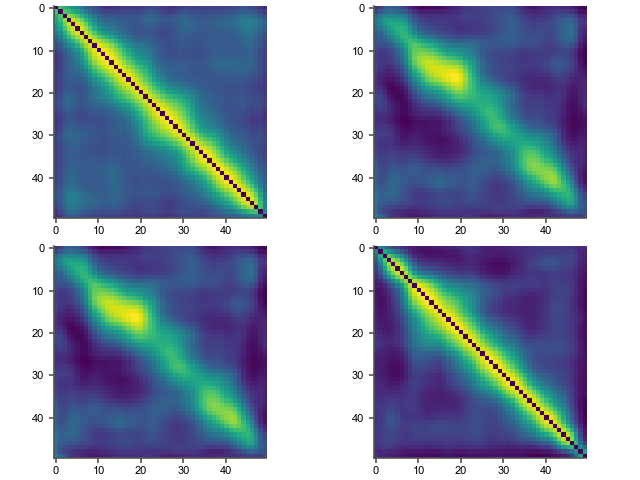

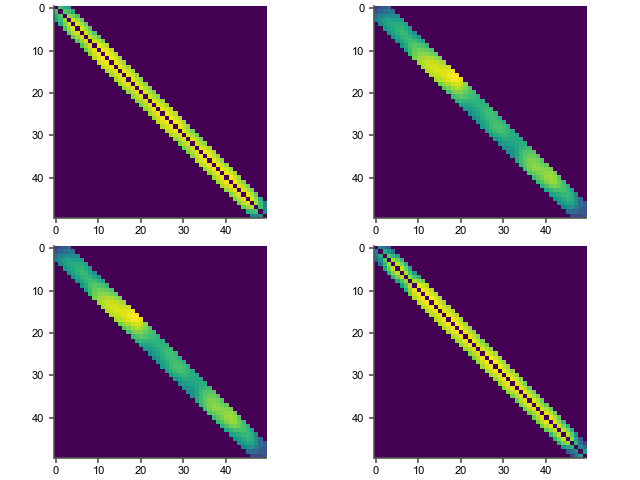

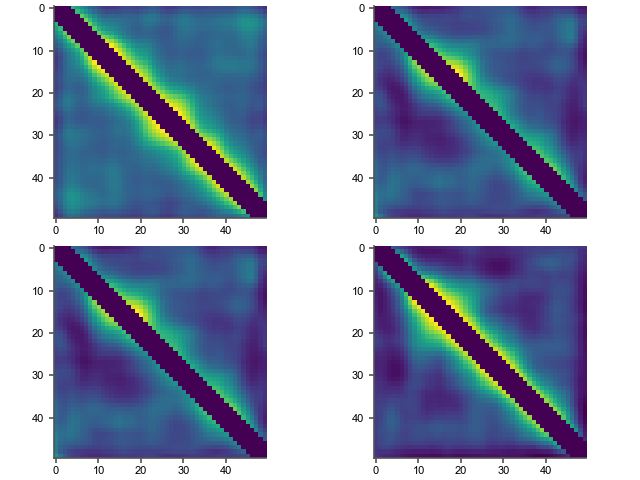

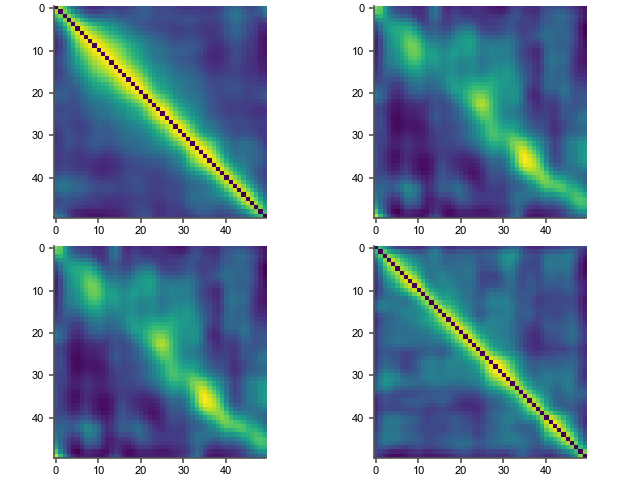

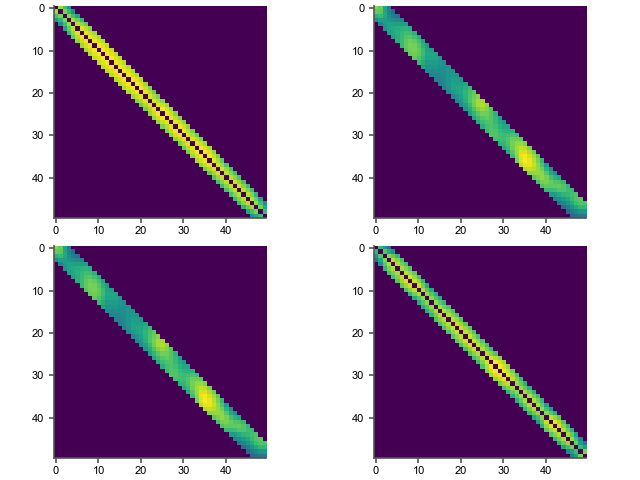

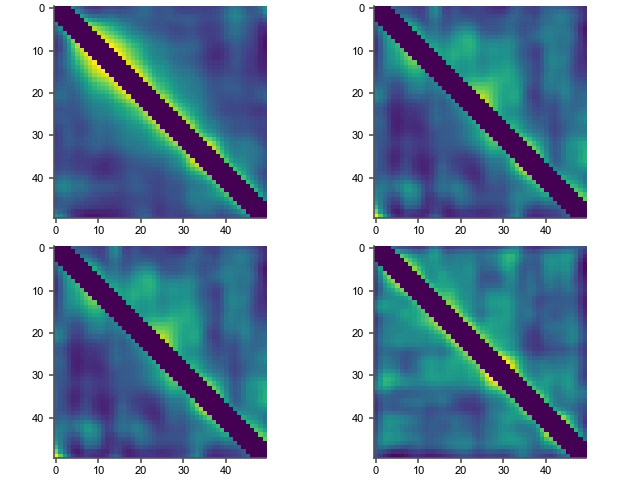

In [105]:
# Another sanity check with the real data
for grp, corr in zip(["NSD", "SD"], corr_all):

    maze_corr = corr[0:nbins_per_sesh,0:nbins_per_sesh]
    remaze_corr = corr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
    maze_remaze_corr = corr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
    noffset = 3
    
    _, ax = plt.subplots(2, 2)
    for a, corr_use in zip(ax.reshape(-1), [maze_corr, maze_remaze_corr, maze_remaze_corr, remaze_corr]):
        a.imshow(corr_use)
    
    _, axd = plt.subplots(2, 2)
    _, ax = plt.subplots(2, 2)
    corr_off, corr_diag = [], []
    for a, ad, corr_use in zip(ax.reshape(-1), axd.reshape(-1), [maze_corr, maze_remaze_corr, maze_remaze_corr, remaze_corr]):
        # c_trim = np.triu(corr_use, noffset)
        c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
        c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)
        a.imshow(c_off)
        ad.imshow(c_diag)
        # corr_off.append(c_trim[c_trim != 0])
        corr_off.append(np.mean(c_off[c_off != 0]))
        # cdiag = np.diagonal(np.triu(corr_use), offset=noffset - 1)
        corr_diag.append(np.mean(c_diag[c_diag != 0]))
        
    print(f'{grp} Off diagonal corrs = {corr_off}')
    print(f'{grp} On diagonal corrs = {corr_diag}')

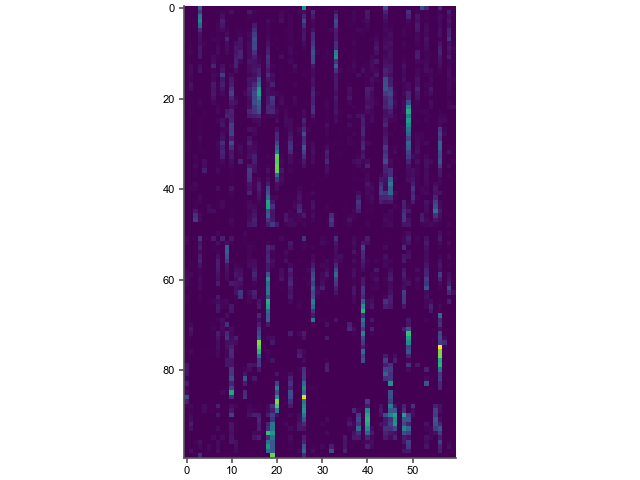

In [215]:
_, ax = plt.subplots()
ax.imshow(tc_sess.T)

In [227]:
tc_sess.shape

(60, 100)

In [231]:
np.corrcoef(tc_sess[~np.all(tc_sess == 0, axis=1)].T)

array([[ 1.        ,  0.38208642,  0.55248083, ...,  0.25824095,
         0.32991484,  0.14872552],
       [ 0.38208642,  1.        ,  0.77336644, ...,  0.0872131 ,
        -0.01775561,  0.03858084],
       [ 0.55248083,  0.77336644,  1.        , ...,  0.10154322,
         0.05622687,  0.13375335],
       ...,
       [ 0.25824095,  0.0872131 ,  0.10154322, ...,  1.        ,
         0.89298727,  0.42846631],
       [ 0.32991484, -0.01775561,  0.05622687, ...,  0.89298727,
         1.        ,  0.52571898],
       [ 0.14872552,  0.03858084,  0.13375335, ...,  0.42846631,
         0.52571898,  1.        ]])

In [211]:
np.corrcoef(tc_sess.T)

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[ 1.        ,  0.38485103,  0.55410414, ...,  0.26091528,
         0.33235749,  0.15014139],
       [ 0.38485103,  1.        ,  0.774634  , ...,  0.092716  ,
        -0.01148878,  0.04124879],
       [ 0.55410414,  0.774634  ,  1.        , ...,  0.10575991,
         0.06072924,  0.13556502],
       ...,
       [ 0.26091528,  0.092716  ,  0.10575991, ...,  1.        ,
         0.89347754,  0.42940546],
       [ 0.33235749, -0.01148878,  0.06072924, ...,  0.89347754,
         1.        ,  0.5263856 ],
       [ 0.15014139,  0.04124879,  0.13556502, ...,  0.42940546,
         0.5263856 ,  1.        ]])

In [977]:
corr_all

[0.7470187479250529,
 0.19559661204979134,
 0.7238809450944884,
 0.2110973289489104,
 0.3815658243100826,
 0.1554269510868712]

MAZE_diag  MAZE_off  reMAZE_diag  reMAZE_off  MAZE-reMAZE_diag  \
0   0.870975  0.434339     0.828957    0.338012          0.518664   
1   0.903563  0.735993     0.863454    0.551304          0.542173   
2   0.904831  0.565264     0.829191    0.297013          0.416214   
3   0.756274  0.256515     0.694114    0.177049          0.413444   
4   0.908355  0.601208     0.865654    0.668334          0.271265   
5   0.856355  0.413025     0.707239    0.257033          0.478101   
6   0.912527  0.619615     0.888362    0.581161          0.648920   
7   0.747019  0.195597     0.723881    0.211097          0.381566   

   MAZE-reMAZE_off  grp  session  
0         0.263809  NSD        0  
1         0.440237  NSD        1  
2         0.362005  NSD        2  
3         0.161747   SD        3  
4         0.251755   SD        4  
5         0.274428   SD        5  
6         0.460078   SD        6  
7         0.155427   SD        7

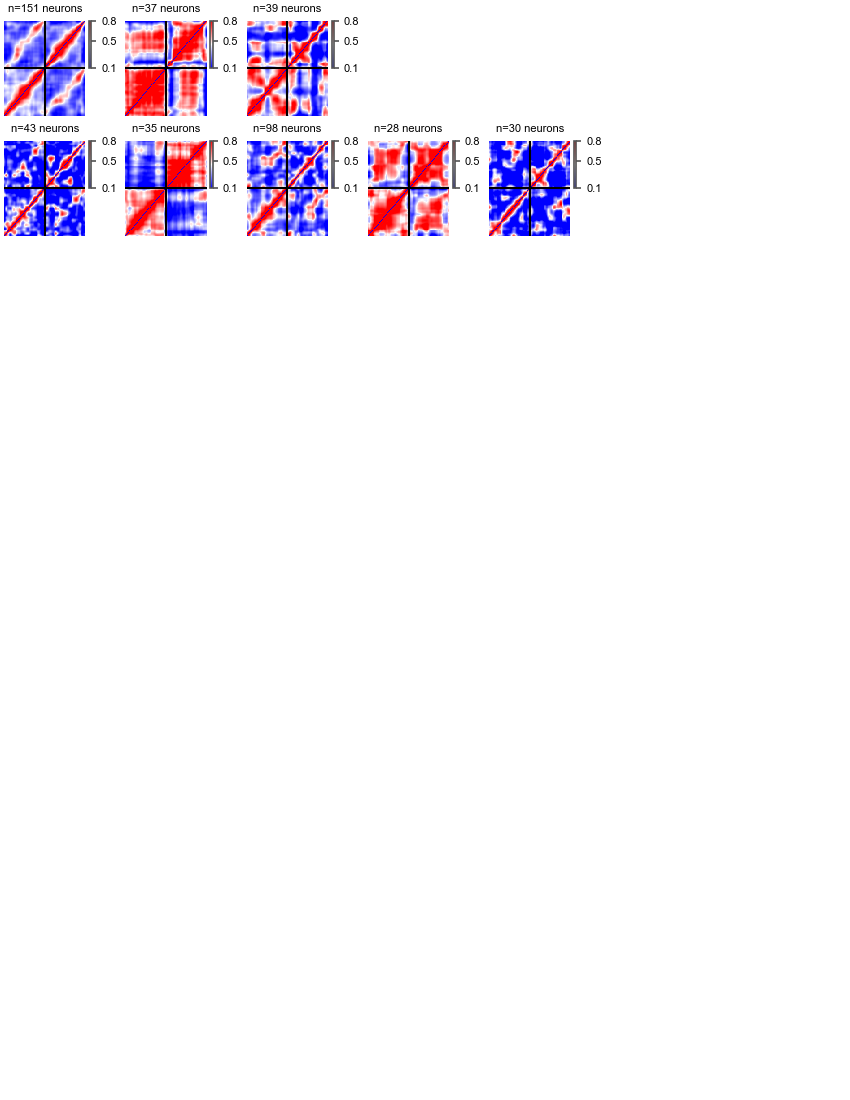

In [976]:
# Calculate PV corr by session
fig = plotting.Fig(11, 8)
noffset = 3

pv_corr_df_sesh = []
idn = 0
for g, grp in enumerate(["NSD", "SD"]):
    # Grab place field firing as a numpy array
    tc_grp = tc_all[tc_all.grp == grp]
    for ids, sess in enumerate(tc_grp.session.unique()):
        tc_sess = tc_grp[tc_grp.session == sess].drop(columns=["grp", "session"]).to_numpy()
    
        ax = fig.subplot(fig.gs[g, ids])
        corr = gaussian_filter(np.corrcoef(tc_sess.T), 1)
        # corr = np.corrcoef(tc_sess.T)
        ax.set_title(f"n={tc_sess.shape[0]} neurons")
        np.fill_diagonal(corr, 0)
        corr_all.append(corr)
        corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
        ax.axvline(nbins_per_sesh, color="k")
        ax.axhline(nbins_per_sesh, color="k")
        ax.axis("off")
        corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

        maze_corr = corr[0:nbins_per_sesh,0:nbins_per_sesh]
        remaze_corr = corr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
        maze_remaze_corr = corr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
        corr_all, fname = [], []
        for corr_name, corr_use in zip(["MAZE", "reMAZE", "MAZE-reMAZE"], [maze_corr, remaze_corr, maze_remaze_corr]):
            c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
            c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)

            # Calculate mean value on diagonal
            corr_all.append(np.nanmean(c_diag[c_diag != 0]))
            fname.append(f"{corr_name}_diag")

            # Calculate mean value on off-diagonal
            corr_all.append(np.nanmean(c_off[c_off != 0]))
            fname.append(f"{corr_name}_off")

        # # Add in grp and session
        # fname.append(grp)
        # fname.append(sess)

        # Make into one dataframe
        # pv_sesh = pd.DataFrame(data=corr_all, columns=fname)
        pv_sesh = pd.DataFrame({f: corr for f, corr in zip(fname, corr_all)}, index=pd.Index([idn]))
        pv_sesh["grp"] = grp
        pv_sesh["session"] = sess
        pv_corr_df_sesh.append(pv_sesh)
        idn += 1
            
pv_corr_df_sesh = pd.concat(pv_corr_df_sesh, axis=0)
pv_corr_df_sesh

In [737]:
nneurons = [sess.neurons.n_neurons for sess in sessions]

In [741]:
nneurons = np.array(nneurons)
nneurons[3:].sum()

724

In [733]:
tc_new_df.grp.unique()

array(['SD'], dtype=object)

In [731]:
302 + 74 + 78

454

In [730]:
86+70+196+56+60

468

In [592]:
tc_temp = tc_grp.drop(columns=["grp", "session"]).to_numpy()
PVmaze = tc_temp[:, 0:nbins_per_sesh]
PVreMAZE = tc_temp[:, nbins_per_sesh:]
np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))

array([[1.       , 0.4378789],
       [0.4378789, 1.       ]])

In [993]:
PVmaze.shape

(468, 50)

In [995]:
PVreMAZE.shape

(468, 50)

In [997]:
PVcorrs.shape

(2, 1000, 100, 100)

In [1000]:
pf_array = tc_all[tc_all.grp == "NSD"].drop(columns=["grp", "session"]).to_numpy()

In [1001]:
PVcorr = np.corrcoef(pf_array.T)
PVcorr.shape

(100, 100)

In [1006]:
np.diag(reMAZEcorr)

array([0.33384317, 0.48316232, 0.59659348, 0.55325221, 0.52945701,
       0.47352713, 0.48313444, 0.48660283, 0.44964874, 0.45381117,
       0.43924967, 0.45635952, 0.49041161, 0.56481729, 0.60669059,
       0.60591303, 0.60546505, 0.63466559, 0.51971973, 0.56611641,
       0.56973399, 0.52967609, 0.46779035, 0.50131316, 0.4194764 ,
       0.42487218, 0.5041431 , 0.52462787, 0.54269224, 0.57413568,
       0.52649531, 0.45903508, 0.45934542, 0.48287205, 0.4597032 ,
       0.5057752 , 0.55734655, 0.50192466, 0.51225246, 0.52889712,
       0.63164734, 0.64989405, 0.61065447, 0.64317424, 0.69255536,
       0.70388601, 0.71786395, 0.68974254, 0.65377629, 0.06656945])

In [1008]:
diag_check = []
for i in range(50):
    diag_check.append(reMAZEcorr[i, i])

np.array(diag_check)

array([0.33384317, 0.48316232, 0.59659348, 0.55325221, 0.52945701,
       0.47352713, 0.48313444, 0.48660283, 0.44964874, 0.45381117,
       0.43924967, 0.45635952, 0.49041161, 0.56481729, 0.60669059,
       0.60591303, 0.60546505, 0.63466559, 0.51971973, 0.56611641,
       0.56973399, 0.52967609, 0.46779035, 0.50131316, 0.4194764 ,
       0.42487218, 0.5041431 , 0.52462787, 0.54269224, 0.57413568,
       0.52649531, 0.45903508, 0.45934542, 0.48287205, 0.4597032 ,
       0.5057752 , 0.55734655, 0.50192466, 0.51225246, 0.52889712,
       0.63164734, 0.64989405, 0.61065447, 0.64317424, 0.69255536,
       0.70388601, 0.71786395, 0.68974254, 0.65377629, 0.06656945])

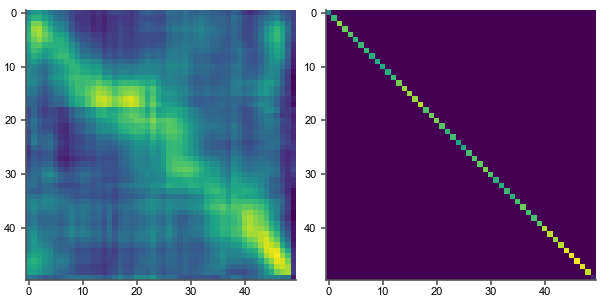

In [1014]:
reMAZEcorr = PVcorr[0:50, 50:]
_, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(reMAZEcorr)
ax[1].imshow(np.diagflat(np.diag(reMAZEcorr)))

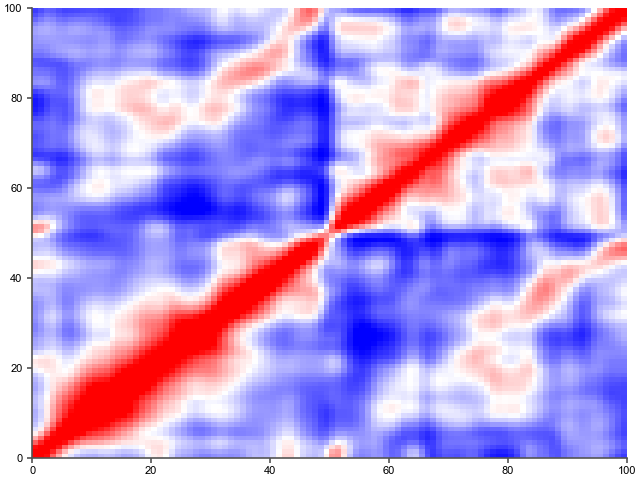

In [1015]:
def calc_PV_corr(pf_df_in, filter_std=0, method: str in ["2D", "Rubin", "Mankin"] = "2D"):
    """Calculates population vectors Input is an nneurons x (nspatialbins * 2) dataframe
    with the last two columns denoting the group and recording session.
    Returns PVcorr, which gives correlations between all spatial bins in MAZE and reMAZE sessions.
    Also returns PVcorr_maze_remaze, consistent with Rubin et al. (2015) but different from Mankin et al. (2012)"""
    # Make into numpy array
    pf_array = pf_df_in.drop(columns=["grp", "session"]).to_numpy()
    assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # Remove any rows with all zeroes or nans - Dont do this - all neurons included are stable, so if they aren't firing much during
    # running they legimately aren't active then but are active at other (non-running) times.
    # pf_array = pf_array[~np.all(pf_array == 0, axis=1)]
    # pf_array = pf_array[~np.all(np.isnan(pf_array), axis=1)]  # There shouldn't by any like this
    
    assert method in ["2D", "Rubin", "Mankin"]
    if method == "Rubin":
        # Calculate MAZE-reMAZE PV corr directly - gives ONE value. Consistent with Rubin et al. (2015)
        PVmaze = pf_array[:, 0:nbins_per_sesh]
        PVreMAZE = pf_array[:, nbins_per_sesh:]
        PVcorr_maze_remaze = np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))[0, 1]
        PVcorr = PVcorr_maze_remaze

    elif method == "2D":

        # Remove any columns (spatial bins) which have all zeros in either MAZE or reMAZE
        bad_cols = np.where(np.all(pf_array == 0, axis=0))[0]
        bad_cols = np.hstack((bad_cols, bad_cols[bad_cols < nbins_per_sesh] + nbins_per_sesh))
        bad_cols = np.hstack((bad_cols, bad_cols[bad_cols >= nbins_per_sesh] - nbins_per_sesh))
        pf_array = np.delete(pf_array, np.unique(bad_cols), axis=1)
        
        # Calc PV corrs across all spatial bins separately and filter
        PVcorr = np.corrcoef(pf_array.T)
        if filter_std > 0:
            PVcorr = gaussian_filter(PVcorr, filter_std)
            
        # Reinsert bins not calucated as nans to keep everything the same shape
        for bad_col in np.unique(bad_cols):
            PVcorr = np.insert(PVcorr, bad_col, np.nan, axis=0)
            PVcorr = np.insert(PVcorr, bad_col, np.nan, axis=1)

    elif method == "Mankin":
        # assert False, "Mankin method not yet implemented"
        # Calc PV corrs across all spatial bins separately and filter
        PVcorr = np.corrcoef(pf_array.T)
        if filter_std > 0:
            PVcorr = gaussian_filter(PVcorr, filter_std)
        reMAZEcorr = PVcorr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
        PVcorr_maze_remaze =  np.diag(reMAZEcorr)
        PVcorr = PVcorr_maze_remaze

    return PVcorr
_, ax = plt.subplots()
ax.pcolormesh(calc_PV_corr(tc_all[tc_all.grp == "SD"], 1, "2D"), cmap='bwr', vmin=0.1, vmax=0.8, rasterized=True)

In [1016]:
calc_PV_corr(tc_all[tc_all.grp == "SD"], 1, "Mankin")

array([0.58518024, 0.58360438, 0.48150288, 0.37588713, 0.31746335,
       0.30068646, 0.32058699, 0.36536797, 0.41109114, 0.44863612,
       0.46971137, 0.46250993, 0.43258199, 0.42253825, 0.41285446,
       0.38688601, 0.38866929, 0.42649882, 0.43768372, 0.42874445,
       0.43790414, 0.46792133, 0.49194334, 0.50286473, 0.49959724,
       0.47821867, 0.45078602, 0.45742652, 0.47522783, 0.47977954,
       0.48580915, 0.50107247, 0.53084753, 0.55536038, 0.58065126,
       0.60483381, 0.61138707, 0.59153969, 0.54817727, 0.5529404 ,
       0.56698666, 0.54544978, 0.50841589, 0.47708467, 0.48153289,
       0.51527862, 0.55058227, 0.54458483, 0.4697343 , 0.38272476])

In [1019]:
def calc_mean_PV_corr(pf_df_in, filter_std=0, noffset=3):
    """Calculates mean PV correlations for MAZE, reMAZE, and MAZE-reMAZE on the diagonal and off the diagonal.
    Input is an nneurons x (nspatialbins * 2) dataframe with the last two columns denoting the group and recording session. 
    The first nspatialbins contain the mean firing rate for each neuron in that direction during MAZE, 
    while the second nspatialbins are the same but for reMAZE"""

    # # Make into numpy array
    # pf_array = pf_df_in.drop(columns=["grp", "session"]).to_numpy()
    # assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # # Remove any rows with all zeroes or nans - Dont do this - all neurons included are stable, so if they aren't firing much during
    # # running they legimately aren't active then but are active at other (non-running) times.
    # # pf_array = pf_array[~np.all(pf_array == 0, axis=1)]
    # # pf_array = pf_array[~np.all(np.isnan(pf_array), axis=1)]  # There shouldn't by any like this

    # # Also calculate MAZE-reMAZE PV corr directly - gives ONE value. Consistent with Rubin et al. (2015)
    # PVmaze = pf_array[:, 0:nbins_per_sesh]
    # PVreMAZE = pf_array[:, nbins_per_sesh:]
    # PVcorr_maze_remaze = np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))[0, 1]

    # # Note that Mankin does it a bit differently, calculating the PV corr at each spatial bin and then averaging
    # # or calculating the mean PV across all bins

    # # Remove any columns (spatial bins) which have all zeros in either MAZE or reMAZE
    # bad_cols = np.where(np.all(pf_array == 0, axis=0))[0]
    # bad_cols = np.hstack((bad_cols, bad_cols[bad_cols < nbins_per_sesh] + nbins_per_sesh))
    # bad_cols = np.hstack((bad_cols, bad_cols[bad_cols >= nbins_per_sesh] - nbins_per_sesh))
    # pf_array = np.delete(pf_array, np.unique(bad_cols), axis=1)
    
    # # Calc PV corrs across all spatial bins separately and filter
    # PVcorr = np.corrcoef(pf_array.T)
    # if filter_std > 0:
    #     PVcorr = gaussian_filter(PVcorr, filter_std)

    # Calculate PV corrs at all time bins
    PVcorr = calc_PV_corr(pf_df_in, filter_std=filter_std, method="2D")
    PVcorr_maze_remaze_Rubin = calc_PV_corr(pf_df_in, filter_std=filter_std, method="Rubin")
    PVcorr_maze_remaze_Mankin = np.mean(calc_PV_corr(pf_df_in, filter_std=filter_std, method="Mankin"))

    # Segregate PVcorr array into appropriate session comparisons
    # assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found after removing all-zero bins"
    maze_corr = PVcorr[0:nbins_per_sesh,0:nbins_per_sesh]
    remaze_corr = PVcorr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
    maze_remaze_corr = PVcorr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
    
    # Calculate on-diagonal and off-diagonal mean corrs
    corr_all, fname = [], []
    for corr_name, corr_use in zip(["MAZE", "reMAZE", "MAZE_reMAZE"], [maze_corr, remaze_corr, maze_remaze_corr]):
        c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
        c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)

        # Calculate mean value on diagonal
        corr_all.append(np.nanmean(c_diag[c_diag != 0]))
        fname.append(f"{corr_name}_diag")

        # Calculate mean value on off-diagonal
        corr_all.append(np.nanmean(c_off[c_off != 0]))
        fname.append(f"{corr_name}_off")

    # Make into one dataframe
    pv_sesh = pd.DataFrame({f: corr for f, corr in zip(fname, corr_all)}, index=pd.Index([idn]))
    pv_sesh["PVcorr_maze_remaze_Rubin"] = PVcorr_maze_remaze_Rubin
    pv_sesh["PVcorr_maze_remaze_Mankin"] = PVcorr_maze_remaze_Mankin
    pv_sesh["grp"] = pf_df_in.reset_index().loc[0, "grp"]
    # pv_sesh["session"] = pf_df_in.loc[0, "session"]

    return pv_sesh

calc_mean_PV_corr(tc_all[tc_all.grp == "SD"], 1, 2)    

MAZE_diag  MAZE_off  reMAZE_diag  reMAZE_off  MAZE_reMAZE_diag  \
8   0.888427  0.450293     0.824735    0.431237          0.465126   

   MAZE_reMAZE_off  PVcorr_maze_remaze_Rubin  PVcorr_maze_remaze_Mankin grp  
8         0.293526                  0.485628                   0.476107  SD

# TODO:
1) Calc Mankin-style PV corrs and plot Mankin-style CDF plots

In [963]:
len(PVcorrs[0][0])

2

In [972]:
PVcorrs = bootstrap_resample(tc_all, 1000, apply=calc_PV_corr, to_df=False, filter_std=0)
PVcorrs = np.array(PVcorrs)

Running bootstraps for NSD group


100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.67it/s]


Running bootstraps for SD group


100%|█████████████████████████████████████████| 1000/1000 [00:03<00:00, 253.10it/s]


In [694]:
# _, ax = plt.subplots()
# ax.imshow(np.moveaxis(PVcorrs, 1, 3)[0, :, :, 0])
np.moveaxis(PVcorrs, 1, 3).shape

(2, 100, 100, 10000)

In [973]:
pval_array, stat_array  = [], []
PVcorrs_rs = np.moveaxis(PVcorrs, 1, 3)  # reorg to 2 x nbins x nbinsx x niterations vector
_, nbins, _, niters = PVcorrs_rs.shape
# Iterate through each spatial bin and calculate bootstrap pvalue
for corr_nsd, corr_sd in zip(PVcorrs_rs[0].reshape(-1, niters), PVcorrs_rs[1].reshape(-1, niters)):
    stat_bin, pval_bin = get_bootstrap_prob(corr_nsd, corr_sd)
    stat_array.append(stat_bin)
    pval_array.append(pval_bin)


In [983]:
calc_PV_corr(tc_all[tc_all.grp == "NSD"]).shape

(100, 100)

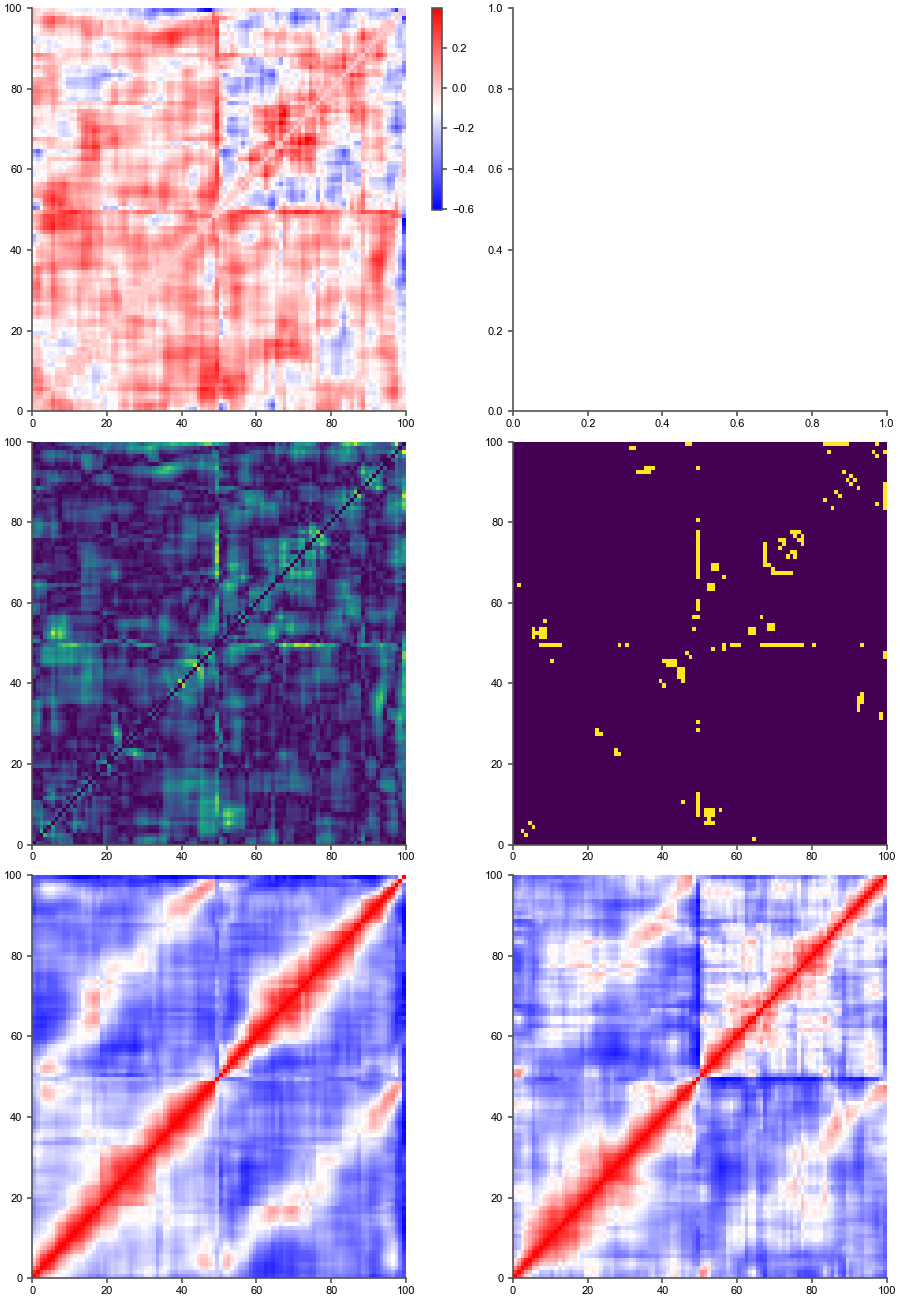

In [986]:
_, ax = plt.subplots(3, 2, figsize=(9, 13))
PVcorrs_nsd = calc_PV_corr(tc_all[tc_all.grp == "NSD"])
PVcorrs_sd = calc_PV_corr(tc_all[tc_all.grp == "SD"])
corr_im = ax[0][0].pcolormesh(PVcorrs_nsd - PVcorrs_sd, cmap="bwr", rasterized=True)  # PVcorr_nsd - PVcorr_sd
corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1))
ax[1, 0].pcolormesh(np.array(stat_array).reshape(nbins, nbins))

ax[1, 1].pcolormesh(np.array(pval_array).reshape(nbins, nbins) < 0.05)

ax[2, 0].pcolormesh(PVcorrs_nsd, cmap="bwr", rasterized=True)
ax[2, 1].pcolormesh(PVcorrs_sd, cmap="bwr", rasterized=True)

In [573]:
bootstrap_resample(tc_all, 10, apply=calc_mean_PV_corr, noffset=10)

Running bootstraps for NSD group


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 222.95it/s]


Running bootstraps for SD group


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 167.86it/s]


MAZE_diag  MAZE_off  reMAZE_diag  reMAZE_off  MAZE-reMAZE_diag  \
0    0.629654  0.235792     0.571584    0.154648          0.352737   
1    0.708906  0.464717     0.586703    0.241141          0.351719   
2    0.643078  0.296352     0.540563    0.153766          0.359101   
3    0.617912  0.226242     0.528662    0.109178          0.344695   
4    0.636568  0.259753     0.554241    0.142322          0.383454   
5    0.651246  0.277704     0.561423    0.117687          0.323192   
6    0.633232  0.221614     0.531416    0.093012          0.354371   
7    0.625722  0.219942     0.533865    0.106221          0.354258   
8    0.687903  0.440132     0.565807    0.169137          0.345606   
9    0.660561  0.293807     0.561488    0.157129          0.389362   
10   0.555811  0.208987     0.472941    0.170577          0.339396   
11   0.554094  0.198259     0.421929    0.157724          0.298929   
12   0.675040  0.272692     0.640064    0.405745          0.335411   
13   0.657604  0.232540     0.593986    0.283993          0.420804   
14   0.749667  0.360919     0.639410    0.423695          0.207807   
15   0.651879  0.286869     0.534124    0.239578          0.433030   
16   0.572467  0.161743     0.446213    0.249402          0.236243   
17   0.613841  0.244620     0.348821    0.114566          0.290861   
18   0.584684  0.192122     0.551247    0.268722          0.301296   
19   0.608149  0.216382     0.510467    0.265752          0.316991   

    MAZE-reMAZE_off  grp  
0          0.145316  NSD  
1          0.265764  NSD  
2          0.174304  NSD  
3          0.118114  NSD  
4          0.154875  NSD  
5          0.110067  NSD  
6          0.117772  NSD  
7          0.093933  NSD  
8          0.248412  NSD  
9          0.161151  NSD  
10         0.177180   SD  
11         0.158313   SD  
12         0.183972   SD  
13         0.192130   SD  
14         0.150878   SD  
15         0.241155   SD  
16         0.130280   SD  
17         0.162713   SD  
18         0.130612   SD  
19         0.170278   SD

In [1026]:
# Bootstrap each group and corr
from stats_utils import bootstrap_resample
exclude_bad_sd = True
tc_all_use = tc_all[(tc_all.session != 4) & (tc_all.session != 5)] if exclude_bad_sd else tc_all
PVcorrs_df_bs = bootstrap_resample(tc_all_use, 1000, apply=calc_mean_PV_corr, filter_std=1, noffset=3)

# Add in other fields
PVcorrs_df_bs["MAZE-reMAZE_diag"] = PVcorrs_df_bs["MAZE_diag"] - PVcorrs_df_bs["reMAZE_diag"]
PVcorrs_df_bs["MAZE-reMAZE_off"] = PVcorrs_df_bs["MAZE_off"] - PVcorrs_df_bs["reMAZE_off"]
PVcorrs_df_bs["MAZE_diff"] = PVcorrs_df_bs["MAZE_diag"] - PVcorrs_df_bs["MAZE_off"]
PVcorrs_df_bs["reMAZE_diff"] = PVcorrs_df_bs["reMAZE_diag"] - PVcorrs_df_bs["reMAZE_off"]

PVcorrs_df_bs

Running bootstraps for NSD group


100%|█████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.27it/s]


Running bootstraps for SD group


100%|█████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.78it/s]


MAZE_diag  MAZE_off  reMAZE_diag  reMAZE_off  MAZE_reMAZE_diag  \
0      0.866081  0.438289     0.837064    0.364305          0.508773   
1      0.917275  0.680202     0.850487    0.501913          0.500658   
2      0.889235  0.504282     0.827163    0.254505          0.373333   
3      0.869822  0.395342     0.834394    0.309383          0.509591   
4      0.880635  0.420778     0.839832    0.344424          0.511936   
...         ...       ...          ...         ...               ...   
1995   0.865125  0.524074     0.851233    0.457396          0.506652   
1996   0.810585  0.418536     0.849885    0.513595          0.543589   
1997   0.829927  0.383595     0.820277    0.433782          0.579722   
1998   0.929335  0.699134     0.864739    0.530271          0.618551   
1999   0.804592  0.383247     0.804576    0.380130          0.362654   

      MAZE_reMAZE_off  PVcorr_maze_remaze_Rubin  PVcorr_maze_remaze_Mankin  \
0            0.260899                  0.523939                   0.528734   
1            0.454836                  0.442303                   0.500151   
2            0.268028                  0.359217                   0.385323   
3            0.224893                  0.532606                   0.527812   
4            0.274098                  0.547170                   0.528224   
...               ...                       ...                        ...   
1995         0.327958                  0.532439                   0.528133   
1996         0.355043                  0.561950                   0.564631   
1997         0.339229                  0.620914                   0.606729   
1998         0.467211                  0.589918                   0.631647   
1999         0.195651                  0.382228                   0.388775   

      grp  MAZE-reMAZE_diag  MAZE-reMAZE_off  MAZE_diff  reMAZE_diff  
0     NSD          0.029016         0.073984   0.427791     0.472759  
1     NSD          0.066788         0.178288   0.237073     0.348574  
2     NSD          0.062071         0.249777   0.384953     0.572658  
3     NSD          0.035428         0.085959   0.474480     0.525011  
4     NSD          0.040803         0.076355   0.459856     0.495408  
...   ...               ...              ...        ...          ...  
1995   SD          0.013892         0.066678   0.341051     0.393837  
1996   SD         -0.039300        -0.095059   0.392049     0.336291  
1997   SD          0.009650        -0.050187   0.446332     0.386495  
1998   SD          0.064596         0.168862   0.230201     0.334467  
1999   SD          0.000015         0.003116   0.421345     0.424446  

[2000 rows x 13 columns]

In [1024]:
PVcorrs_bs[PVcorrs_bs.grp == "NSD"]

MAZE_diag  MAZE_off  reMAZE_diag  reMAZE_off  MAZE_reMAZE_diag  \
0      0.647565  0.326351     0.556226    0.181912          0.334494   
1      0.591852  0.204102     0.529560    0.127623          0.314071   
2      0.603000  0.181792     0.543627    0.117890          0.372518   
3      0.724222  0.489026     0.584173    0.254349          0.359562   
4      0.633392  0.257141     0.548063    0.124033          0.358790   
...         ...       ...          ...         ...               ...   
9995   0.643811  0.253765     0.558192    0.122331          0.342304   
9996   0.726395  0.487473     0.563559    0.198772          0.360760   
9997   0.607391  0.208754     0.539844    0.107904          0.311078   
9998   0.619202  0.241217     0.544098    0.129409          0.290670   
9999   0.666067  0.310945     0.589214    0.190367          0.395740   

      MAZE_reMAZE_off  PVcorr_maze_remaze  grp  MAZE-reMAZE_diag  \
0            0.178456            0.474438  NSD          0.091339   
1            0.117176            0.470503  NSD          0.062291   
2            0.109773            0.559069  NSD          0.059372   
3            0.283864            0.427789  NSD          0.140048   
4            0.136881            0.524242  NSD          0.085329   
...               ...                 ...  ...               ...   
9995         0.122932            0.481636  NSD          0.085618   
9996         0.278384            0.400294  NSD          0.162837   
9997         0.096422            0.493289  NSD          0.067546   
9998         0.105415            0.449219  NSD          0.075103   
9999         0.185092            0.556693  NSD          0.076853   

      MAZE-reMAZE_off  MAZE_diff  reMAZE_diff  
0            0.144439   0.321214     0.374315  
1            0.076478   0.387750     0.401937  
2            0.063902   0.421208     0.425737  
3            0.234677   0.235196     0.329824  
4            0.133109   0.376250     0.424030  
...               ...        ...          ...  
9995         0.131434   0.390045     0.435861  
9996         0.288701   0.238923     0.364787  
9997         0.100851   0.398636     0.431941  
9998         0.111809   0.377984     0.414689  
9999         0.120578   0.355122     0.398847  

[10000 rows x 12 columns]

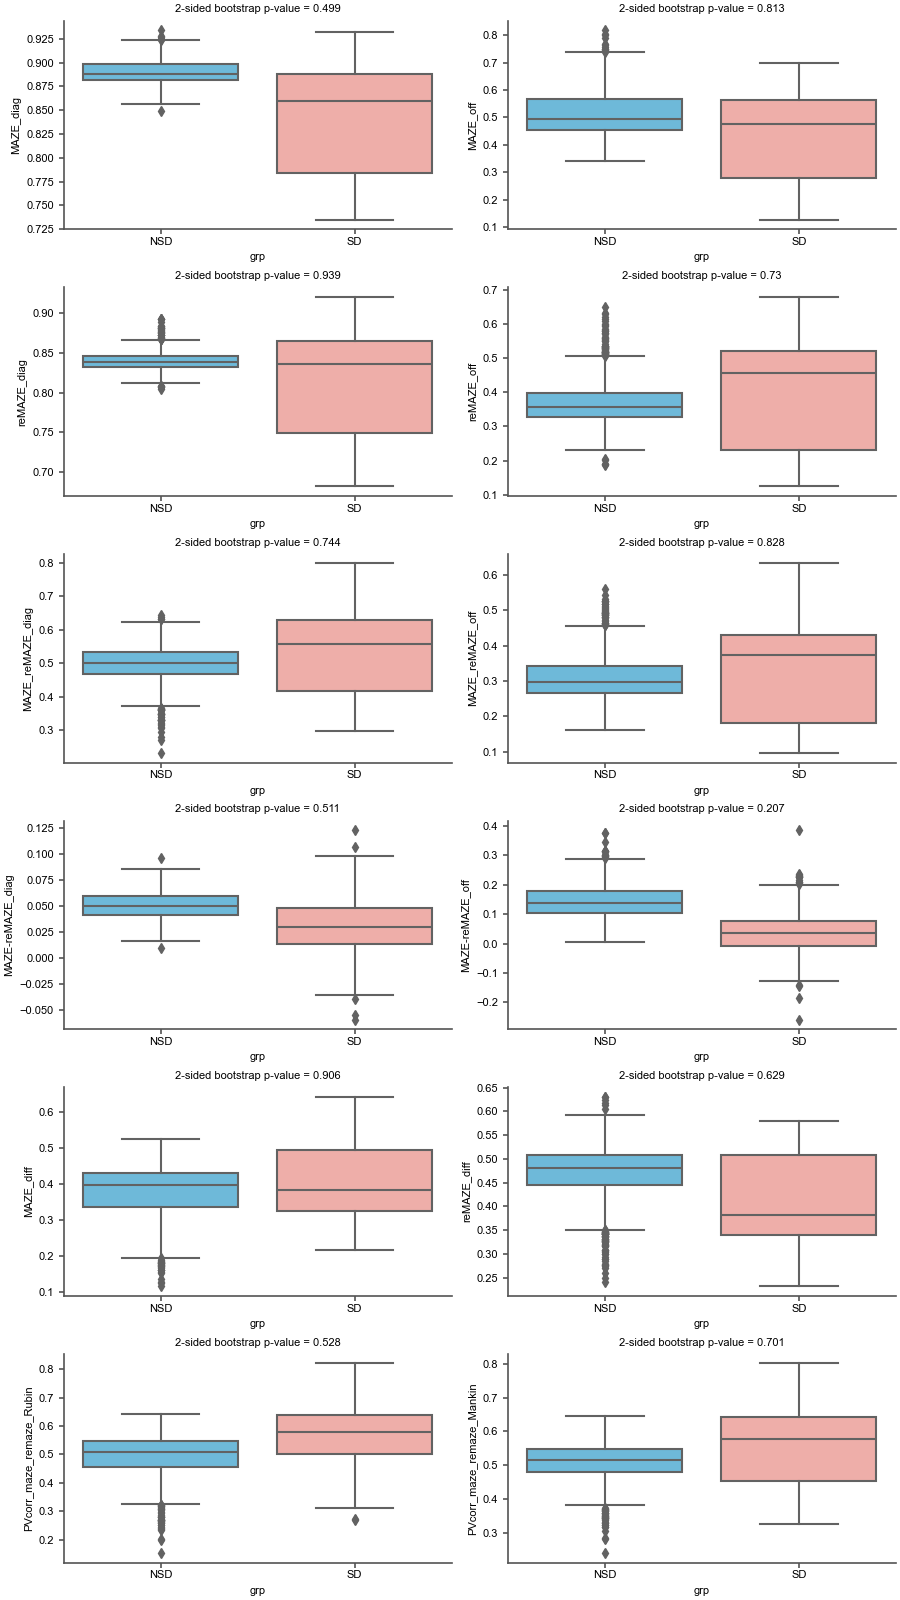

In [1028]:
# Visualize
from stats_utils import get_bootstrap_prob
_, ax = plt.subplots(6, 2, figsize=(9, 16))
for a, comp in zip(ax.reshape(-1), ["MAZE_diag", "MAZE_off", "reMAZE_diag",	"reMAZE_off", "MAZE_reMAZE_diag", "MAZE_reMAZE_off",
                                    "MAZE-reMAZE_diag", "MAZE-reMAZE_off", "MAZE_diff", "reMAZE_diff", 
                                    "PVcorr_maze_remaze_Rubin", "PVcorr_maze_remaze_Mankin"]):
    sns.boxplot(data=PVcorrs_df_bs, x="grp", y=comp, ax=a)
    stat, pval = get_bootstrap_prob(PVcorrs_df_bs.loc[PVcorrs_df_bs.grp == "NSD", comp], PVcorrs_df_bs.loc[PVcorrs_df_bs.grp == "SD", comp])
    a.set_title(f"2-sided bootstrap p-value = {2*pval:0.3g}")

#### Quantify PF Correlations

In [145]:
def pf_corr_maze_remaze(row, nbins_each_sesh=50):
    """Calculate PF correlation for each row/neuron"""
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]
    

    return np.corrcoef([maze_tc, remaze_tc])[0, 1]

In [231]:
test_mid = tc_all.drop(columns=["grp" ,"session"]).apply(pf_corr_maze_remaze_middle, axis=1)

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [275]:
tc_all.drop(columns=["grp" ,"session"]).apply(get_pf_loc, axis=1).head(12)

0        end
1        end
2        end
3        end
4     middle
5        end
6     middle
7     middle
8        end
9     middle
10    middle
11    middle
dtype: object

In [274]:
def get_pf_loc(row, nbins_each_sesh=50, end_prop=0.125):

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)
    
    if (imax < (nbins_each_sesh * end_prop)) | (imax > (nbins_each_sesh - nbins_each_sesh * end_prop)):
        loc = "end"
    else:
        loc = "middle"

    return loc

In [263]:
def pf_corr_maze_remaze_ends(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate PF correlation for each row/neuron but only consider neurons with peaks in at the end of the tracks,
    within `end_prop` of the end of the track"""

    # Calculate correlations
    pf_corr_row = pf_corr_maze_remaze(row, nbins_each_sesh=nbins_each_sesh)

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    if (imax < (nbins_each_sesh * end_prop)) | (imax > (nbins_each_sesh - nbins_each_sesh * end_prop)):
        return pf_corr_row
    else:
        return np.nan


In [234]:
def get_imax(row):
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    return imax

In [229]:
def pf_corr_maze_remaze_middle(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate PF correlation for each row/neuron but only consider neurons with peaks in at the end of the tracks,
    within `end_prop` of the end of the track"""

    # Calculate correlations
    pf_corr_row = pf_corr_maze_remaze(row, nbins_each_sesh=nbins_each_sesh)

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    if (imax > (nbins_each_sesh * end_prop)) & (imax < (nbins_each_sesh - nbins_each_sesh * end_prop)):
        return pf_corr_row
    else:
        return np.nan


In [147]:
def delta_rate_index(row, nbins_each_sesh=50, use_same_peak_bin=False):
    """Calculate change in max firing rate from MAZE to REMAZE for each row/neuron"""
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]
    
    maze_max = np.nanmax(maze_tc)
    remaze_max = np.nanmax(remaze_tc)
    if use_same_peak_bin:
        imax = np.argmax(maze_tc)
        remaze_max = remaze_tc[imax]
    
    return (maze_max - remaze_max) / (maze_max + remaze_max)

In [148]:
def delta_pf_peak(row, nbins_each_sesh=50):
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]

    return np.argmax(maze_tc) - np.argmax(remaze_tc)

In [828]:
delta_rate_ind

0           NaN
1           NaN
2      0.100264
3           NaN
4           NaN
         ...   
463         NaN
464    0.035034
465    0.037244
466    0.312934
467    0.209188
Length: 922, dtype: float64

In [867]:
tc_new_df

0         1         2         3         4         5         6  \
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2    0.613856  0.452430  0.245044  0.096983  0.027828  0.005732  0.000834   
3         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4    0.498665  0.340796  0.158839  0.050349  0.010835  0.001583  0.000152   
..        ...       ...       ...       ...       ...       ...       ...   
917  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
918  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
919  0.014001  0.027951  0.047670  0.058163  0.050045  0.030198  0.013006   
920  0.092577  0.062302  0.028093  0.008426  0.001667  0.000216  0.000017   
921  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            7         8         9  ...        95        96        97  \
0         NaN       NaN       NaN  ...       NaN       NaN       NaN   
1         NaN       NaN       NaN  ...  0.000000  0.000000  0.000000   
2    0.000081  0.000004  0.000000  ...  0.501978  0.440723  0.269721   
3         NaN       NaN       NaN  ...       NaN       NaN       NaN   
4    0.000005  0.000000  0.000000  ...       NaN       NaN       NaN   
..        ...       ...       ...  ...       ...       ...       ...   
917  0.000000  0.000000  0.000000  ...       NaN       NaN       NaN   
918  0.000000  0.000000  0.000000  ...  0.050475  0.157141  0.342608   
919  0.006154  0.010883  0.027222  ...  0.000000  0.000000  0.000000   
920  0.000000  0.000000  0.000000  ...  0.118327  0.281176  0.491989   
921  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

           98        99  session  grp   PF Corr  Delta_rate_index  comp  
0         NaN       NaN        0  NSD       NaN               NaN     1  
1    0.000000  0.000000        0  NSD       NaN               NaN     1  
2    0.114439  0.038768        0  NSD -0.095541          0.100264     1  
3         NaN       NaN        0  NSD       NaN               NaN     1  
4         NaN       NaN        0  NSD       NaN               NaN     1  
..        ...       ...      ...  ...       ...               ...   ...  
917       NaN       NaN        5   SD       NaN               NaN     1  
918  0.544207  0.668329        5   SD  0.787903          0.035034     1  
919  0.000000  0.000000        5   SD -0.207150          0.037244     1  
920  0.679906  0.787922        5   SD  0.992001          0.312934     1  
921  0.000000  0.000000        5   SD  0.184398          0.209188     1  

[922 rows x 105 columns]

In [872]:
maze_max_use = row[:50].reset_index(drop=True).max()

In [874]:
imax = np.argmax(row[:50].reset_index(drop=True))

In [875]:
maze_max_use

0.36704677786050144

In [876]:
row[50:].reset_index(drop=True)[imax]

0.0

In [871]:
remaze_max_use = row[50:].reset_index(drop=True).max()

In [873]:
(maze_max_use  - remaze_max_use ) / (maze_max_use  + remaze_max_use)

-0.20918782224173713

In [846]:
delta_rate_index(row[1])

0.2491861513086271

In [866]:
pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"])

0         1         2         3         4         5         6   \
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2    0.613856  0.452430  0.245044  0.096983  0.027828  0.005732  0.000834   
3         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4    0.498665  0.340796  0.158839  0.050349  0.010835  0.001583  0.000152   
..        ...       ...       ...       ...       ...       ...       ...   
463  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
464  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
465  0.014001  0.027951  0.047670  0.058163  0.050045  0.030198  0.013006   
466  0.092577  0.062302  0.028093  0.008426  0.001667  0.000216  0.000017   
467  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           7         8         9   ...        90        91        92  \
0         NaN       NaN       NaN  ...       NaN       NaN       NaN   
1         NaN       NaN       NaN  ...  0.007551  0.001734  0.000272   
2    0.000081  0.000004  0.000000  ...  0.004338  0.023692  0.087931   
3         NaN       NaN       NaN  ...       NaN       NaN       NaN   
4    0.000005  0.000000  0.000000  ...       NaN       NaN       NaN   
..        ...       ...       ...  ...       ...       ...       ...   
463  0.000000  0.000000  0.000000  ...       NaN       NaN       NaN   
464  0.000000  0.000000  0.000000  ...  0.000000  0.000007  0.000168   
465  0.006154  0.010883  0.027222  ...  0.000000  0.000000  0.000000   
466  0.000000  0.000000  0.000000  ...  0.000000  0.000072  0.000883   
467  0.000000  0.000000  0.000000  ...  0.000748  0.000057  0.000000   

           93        94        95        96        97        98        99  
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1    0.000029  0.000001  0.000000  0.000000  0.000000  0.000000  0.000000  
2    0.224925  0.401131  0.501978  0.440723  0.269721  0.114439  0.038768  
3         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
..        ...       ...       ...       ...       ...       ...       ...  
463       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
464  0.001671  0.011131  0.050475  0.157141  0.342608  0.544207  0.668329  
465  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
466  0.006832  0.034684  0.118327  0.281176  0.491989  0.679906  0.787922  
467  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[922 rows x 100 columns]

In [868]:
row = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).iloc[-1]

In [850]:
row[1]

0     0.001733
1     0.003744
2     0.007361
3     0.010864
4     0.011487
        ...   
95    0.008626
96    0.043592
97    0.145336
98    0.322309
99    0.478932
Name: 467, Length: 100, dtype: float64

In [877]:
pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(delta_rate_index, axis=1, nbins_each_sesh=50, 
                                                                     use_same_peak_bin=True)

/tmp/ipykernel_12968/1866033896.py:6: RuntimeWarning: All-NaN slice encountered
  maze_max = np.nanmax(maze_tc)
/tmp/ipykernel_12968/1866033896.py:7: RuntimeWarning: All-NaN slice encountered
  remaze_max = np.nanmax(remaze_tc)


0           NaN
1           NaN
2      1.000000
3           NaN
4           NaN
         ...   
463         NaN
464    0.067575
465    1.000000
466   -0.312934
467    1.000000
Length: 922, dtype: float64

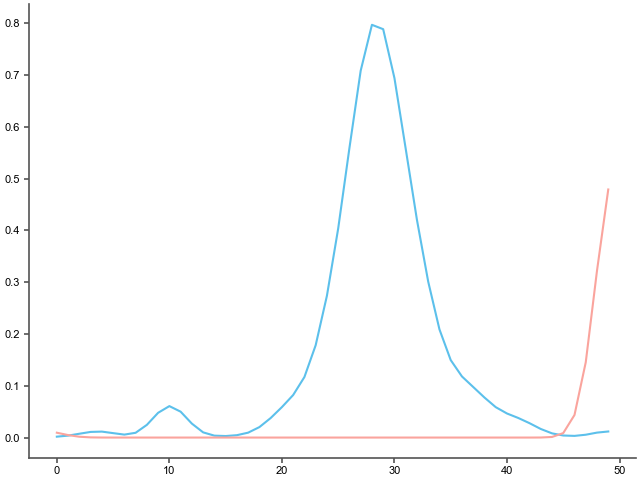

In [839]:
_, ax = plt.subplots()
ax.plot(row[1][:50].reset_index(drop=True))
ax.plot(row[1][50:].reset_index(drop=True))

In [761]:
corrs

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.28561388733881377,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.023081957424311336,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.09288093945367515,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.7931973415246352,
 nan,
 nan,
 nan,
 nan,
 -0.0579309095211687,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.15408787570275,
 nan,
 nan,
 nan,
 nan,
 0.6140412227152501,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -0.3894694671217265,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.6593553980412467,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.6370912204992837,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.7297187168346281,
 -0.015691623907191112,
 0.06641693839564779,
 0.32072282238412225,
 0.4395018006804145,
 0.37938939131424937,
 0.22016810680935817,
 -0.12105874707891355,
 0.6850927508724678,
 0.4869061824706025,
 -0.24171254808953135,
 0.8553513466628

In [837]:
pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(delta_rate_index, axis=1, nbins_each_sesh=50, 
                                                                     use_same_peak_bin=True)

/tmp/ipykernel_12968/1866033896.py:6: RuntimeWarning: All-NaN slice encountered
  maze_max = np.nanmax(maze_tc)
/tmp/ipykernel_12968/1866033896.py:7: RuntimeWarning: All-NaN slice encountered
  remaze_max = np.nanmax(remaze_tc)


0           NaN
1           NaN
2      1.000000
3           NaN
4           NaN
         ...   
463         NaN
464    0.067575
465    1.000000
466   -0.312934
467    1.000000
Length: 922, dtype: float64

In [838]:
row[1]

(467,
 0     0.001733
 1     0.003744
 2     0.007361
 3     0.010864
 4     0.011487
         ...   
 95    0.008626
 96    0.043592
 97    0.145336
 98    0.322309
 99    0.478932
 Name: 467, Length: 100, dtype: float64)

In [146]:
# Calculate PF correlations
from copy import deepcopy

use_same_peak_bin = True
corrs = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(pf_corr_maze_remaze, axis=1)
delta_rate_ind = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(delta_rate_index, axis=1, use_same_peak_bin=True).abs()
delta_peak_bin = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(delta_pf_peak, axis=1).abs()
tc_new_df = deepcopy(pd.concat(tc_new_all, axis=0).reset_index(drop=True))
tc_new_df["PF Corr"] = corrs.values
tc_new_df["Delta_rate_index"] = delta_rate_ind.values
tc_new_df["Delta_peak_bin"] = delta_peak_bin.values
tc_new_df["comp"] = 1

NameError: name 'tc_new_all' is not defined

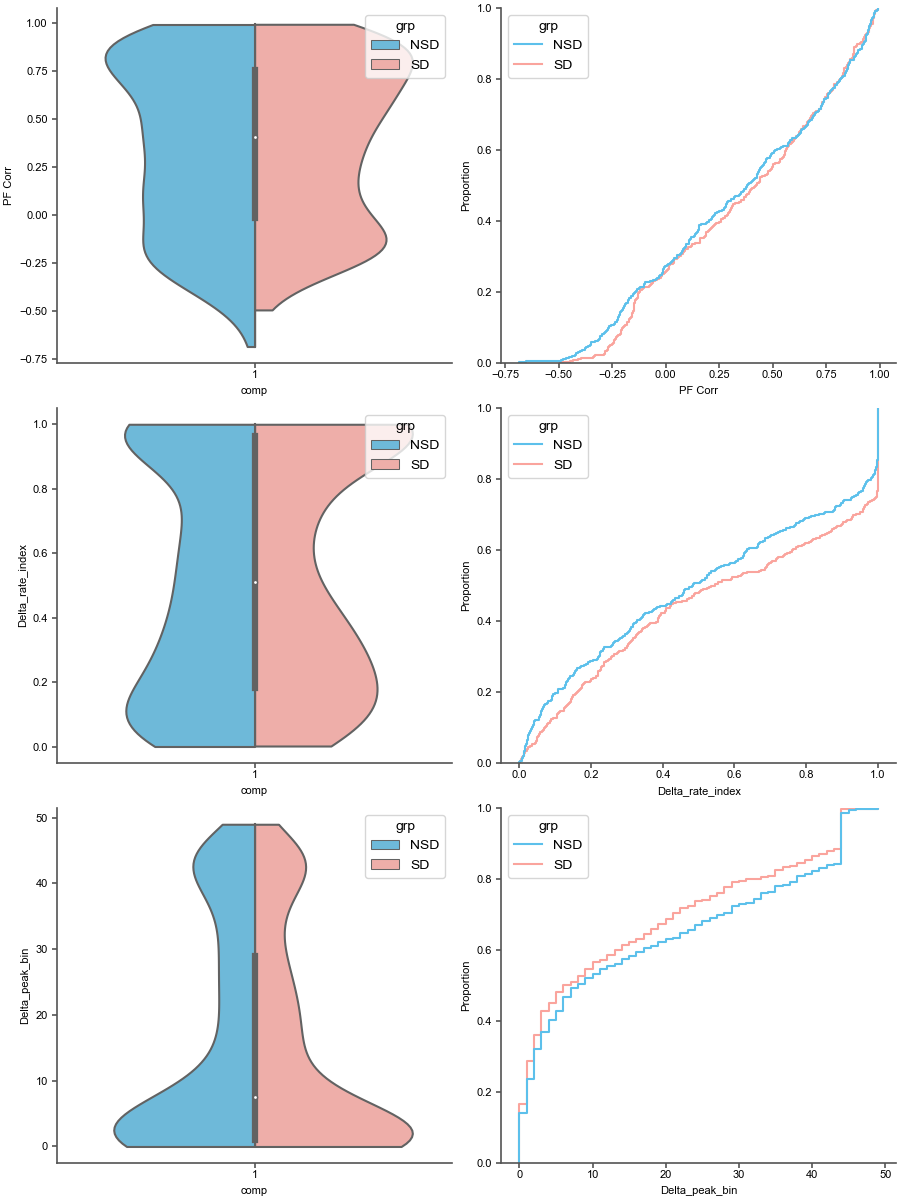

In [896]:
_, axs = plt.subplots(3, 2, figsize=(9, 12))

for metric, ax in zip(["PF Corr", "Delta_rate_index", "Delta_peak_bin"], axs):
    sns.violinplot(data=tc_new_df, x="comp", y=metric, hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=tc_new_df, x=metric, hue="grp", ax=ax[1])

### Plot PF Correlations by position on track

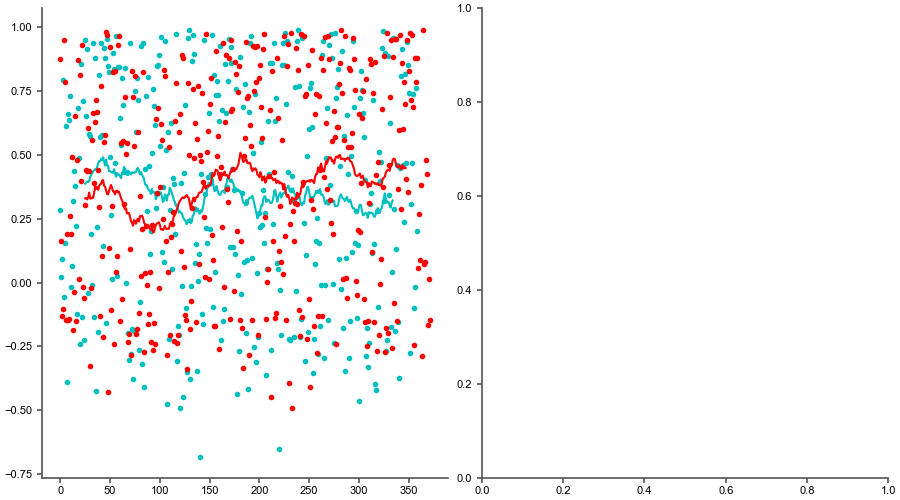

In [52]:
_, ax = plt.subplots(1, 2, figsize=(9, 5))
window = 50
for col, grp in zip(["c", "r"], ["NSD", "SD"]):
    corrs = tc_new_df[tc_new_df.grp == grp]["PF Corr"]
    ax[0].plot(corrs[~np.isnan(corrs)].values, '.', color=col)
    ax[0].plot(corrs[~np.isnan(corrs)].rolling(window, center=True).mean().values, color=col)

# sns.ecdfplot(data=tc_new_df, x="index", y="PF Corr", ax=ax[1], hue="grp")